## Series temporales a los tópicos

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from tslearn.piecewise import PiecewiseAggregateApproximation, SymbolicAggregateApproximation

from utils import cargar_dataset, agrupar, generar_random_walk, generar_ruido_blanco

In [2]:
# 1. Cargar datos
df = cargar_dataset(acotar=True)

df.head()

id  timestamp  \
0  https://europa.eu/eures/portal/jv-se/jv-detail... 2025-10-10   
1  https://europa.eu/eures/portal/jv-se/jv-detail... 2025-10-10   
2  https://europa.eu/eures/portal/jv-se/jv-detail... 2025-10-10   
3  https://europa.eu/eures/portal/jv-se/jv-detail... 2025-10-10   
4  https://europa.eu/eures/portal/jv-se/jv-detail... 2025-10-10   

                provincia                                             titulo  \
0                Asturias           AGENTE COMERCIAL DE SEGUROS (REF.: 6891)   
1                  Huesca  PERSONAL CONDUCCIÓN DE CAMIONES RÍGIDOS Y GÓND...   
2              Las Palmas                                EDUCADORES SOCIALES   
3          Islas Baleares                        PIZZERO (REF. 042025002051)   
4  Santa Cruz de Tenerife                 INTÉRPRETES DE LA LENGUA DE SIGNOS   

   sentimiento  Hostelería y Turismo  Sanitario y Salud  \
0            0              0.041404           0.120992   
1            0              0.030990           0.057478   
2            0              0.091403           0.192666   
3            0              0.322015           0.063957   
4            0              0.080653           0.092984   

   Educación y Formación  Tecnología y Telecomunicaciones  \
0               0.041573                         0.059019   
1               0.036322                         0.029180   
2               0.193061                         0.050125   
3               0.053818                         0.034641   
4               0.213507                         0.103557   

   Construcción e Inmobiliaria  ...  Administración y Finanzas  \
0                     0.030701  ...                   0.324229   
1                     0.147316  ...                   0.018703   
2                     0.051813  ...                   0.115608   
3                     0.071745  ...                   0.064199   
4                     0.021882  ...                   0.032568   

   Cultura, Arte y Ocio  topico_0  topico_1  topico_2  topico_3  topico_4  \
0              0.019733  0.026325  0.026326  0.814183  0.026330  0.027860   
1              0.017910  0.009713  0.688852  0.009849  0.009813  0.009709   
2              0.070124  0.057161  0.332506  0.055559  0.331964  0.055559   
3              0.136239  0.595359  0.023262  0.023261  0.134708  0.023259   
4              0.312488  0.026320  0.026772  0.026344  0.026321  0.026319   

   topico_5  topico_6  topico_7  
0  0.026326  0.026325  0.026325  
1  0.252614  0.009740  0.009709  
2  0.055561  0.056131  0.055560  
3  0.023263  0.153550  0.023339  
4  0.026320  0.814982  0.026622  

[5 rows x 23 columns]

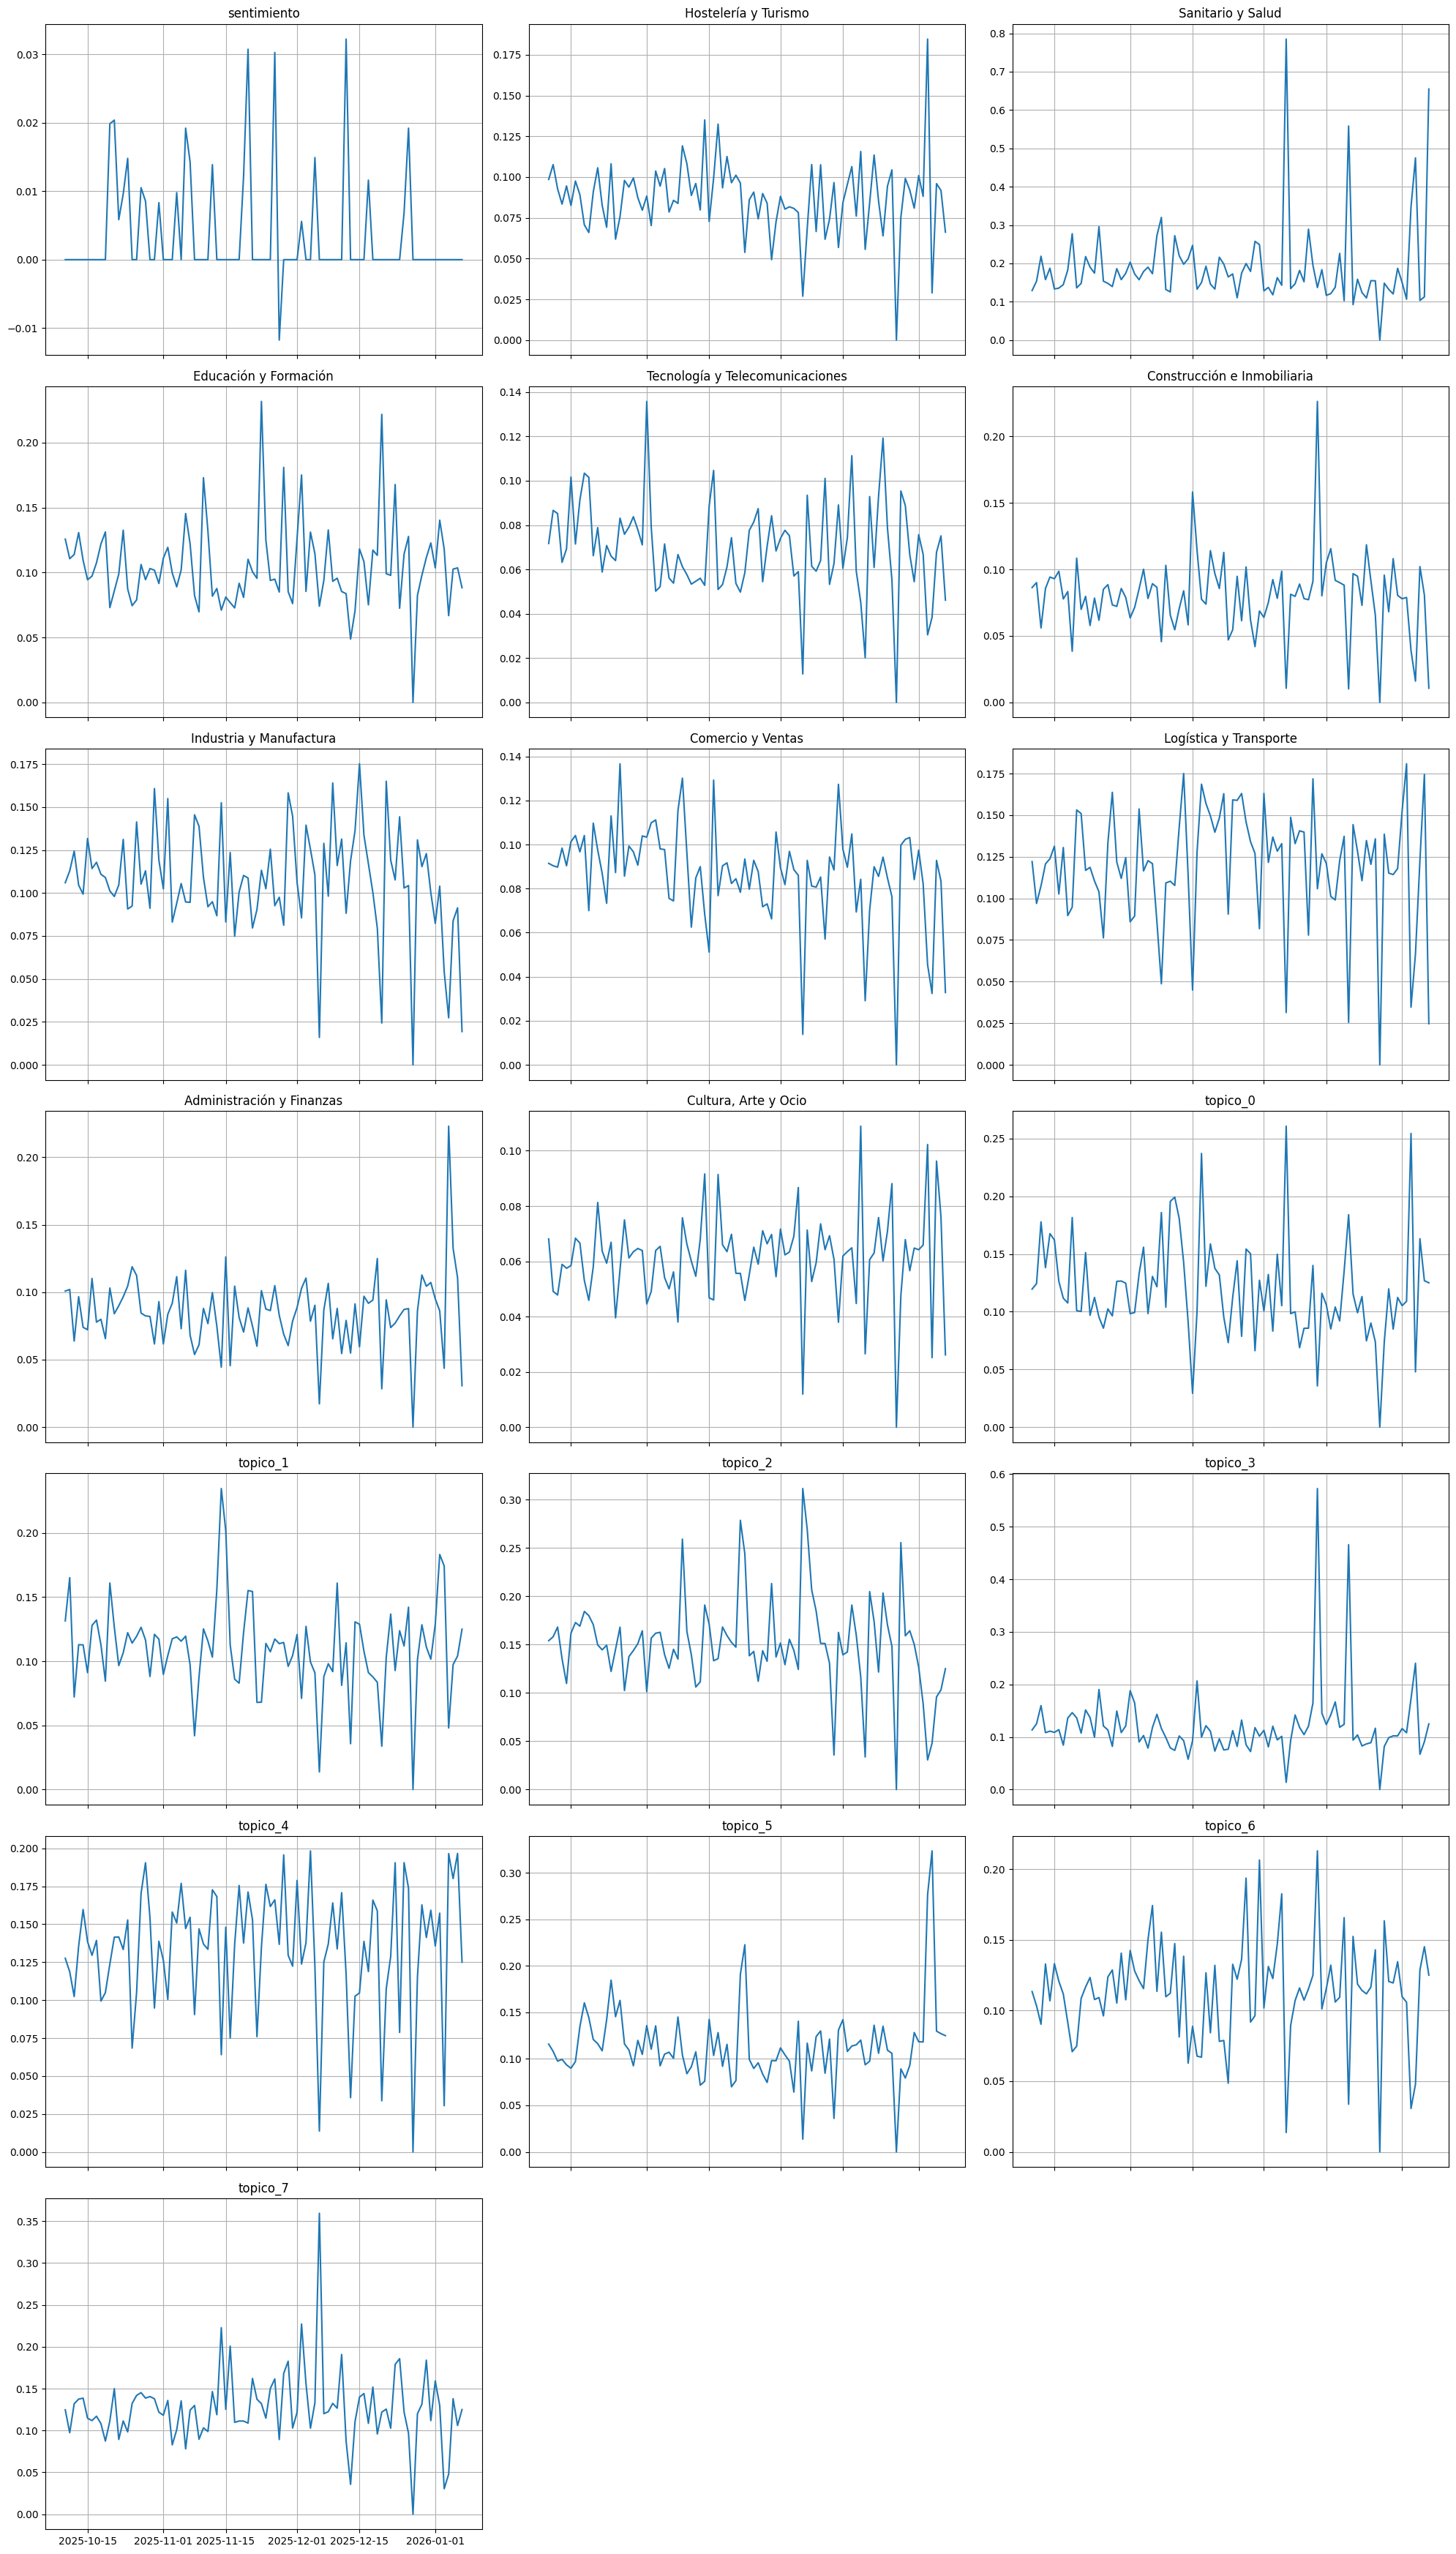

In [3]:
columnas_excluir = ["provincia", "titulo", "id", "timestamp"]
indicadores = [col for col in df.columns if col not in columnas_excluir]

# 3. Configurar subplots: 3 por fila
n_cols = 3
n_rows = int(np.ceil(len(indicadores) / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5*n_rows), sharex=True)
axes = axes.flatten()

# 4. Graficar cada indicador en su subplot
for i, indicador in enumerate(indicadores):
    series_diaria = agrupar(df, indicador, freq="D")
    axes[i].plot(series_diaria.index, series_diaria.values)
    axes[i].set_title(indicador)
    axes[i].grid(True)

# 5. Eliminar subplots vacíos si sobran
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [4]:
# Lista de tópicos a procesar 
topicos = [col for col in df.columns if 'topico' in col]

series_dict = {}

for indicador in topicos:
    # Agrupar por días
    serie = agrupar(df, indicador, freq="D")
    serie = serie.replace(0, np.nan).ffill()
    series_dict[indicador] = serie

# Crear un nuevo DataFrame con todas las series procesadas
df_series_temporales = pd.DataFrame(series_dict)

df_series_temporales

topico_0  topico_1  topico_2  topico_3  topico_4  topico_5  \
timestamp                                                                
2025-10-10  0.119587  0.131459  0.153999  0.113355  0.127572  0.115938   
2025-10-11  0.124357  0.165141  0.158053  0.125143  0.118666  0.108106   
2025-10-12  0.177816  0.072119  0.168140  0.159695  0.102363  0.097574   
2025-10-13  0.138142  0.112881  0.135292  0.108233  0.135611  0.099507   
2025-10-14  0.167609  0.112767  0.109777  0.111071  0.159719  0.093592   
...              ...       ...       ...       ...       ...       ...   
2026-01-03  0.254355  0.174218  0.030620  0.172728  0.030433  0.276452   
2026-01-04  0.047901  0.047996  0.047956  0.240220  0.196511  0.323616   
2026-01-05  0.163206  0.097385  0.095829  0.067027  0.180086  0.129854   
2026-01-06  0.126907  0.104074  0.103139  0.091007  0.196643  0.127115   
2026-01-07  0.125000  0.125000  0.125000  0.125000  0.125000  0.125000   

            topico_6  topico_7  
timestamp                       
2025-10-10  0.113386  0.124704  
2025-10-11  0.103245  0.097288  
2025-10-12  0.090305  0.131989  
2025-10-13  0.132872  0.137462  
2025-10-14  0.106850  0.138615  
...              ...       ...  
2026-01-03  0.030719  0.030475  
2026-01-04  0.047901  0.047900  
2026-01-05  0.128644  0.137969  
2026-01-06  0.145110  0.106006  
2026-01-07  0.125000  0.125000  

[90 rows x 8 columns]

## Buscamos estacionariedad en las series temporales.

In [5]:
# 4. Test de estacionariedad (ADF)
resultados_adf = []

for column in df_series_temporales.columns:
    result = adfuller(df_series_temporales[column])
    adf_stat = result[0]
    p_value = round(result[1], 3)
    es_estacionaria = p_value < 0.05
    
    resultados_adf.append({
        'Topico': column,
        'ADF Statistic': adf_stat,
        'p-value': p_value,
        'Estacionaria': es_estacionaria
    })

# Convertir a DataFrame para mejor visualización
pd.DataFrame(resultados_adf)


Topico  ADF Statistic  p-value  Estacionaria
0  topico_0      -9.067007    0.000          True
1  topico_1      -3.463608    0.009          True
2  topico_2      -6.525954    0.000          True
3  topico_3      -8.377698    0.000          True
4  topico_4      -1.999306    0.287         False
5  topico_5      -6.454042    0.000          True
6  topico_6      -9.037406    0.000          True
7  topico_7      -8.698243    0.000          True

podemos ver que todos los tópicos salvo el 4 son estacionarios, por tanto tendremos que integrar el tópico 4 para conseguir estacionariedad

In [6]:
result = adfuller(df_series_temporales['topico_4'].diff().dropna())

adf_stat = result[0]
p_value = round(result[1], 3)
es_estacionaria = p_value < 0.05

resultado_diff = {
    'Topico': 'topico_4 (Diferenciado)',
    'ADF Statistic': adf_stat,
    'p-value': p_value,
    'Estacionaria': es_estacionaria}

# Mostrar el resultado como DataFrame
pd.DataFrame([resultado_diff])

Topico  ADF Statistic  p-value  Estacionaria
0  topico_4 (Diferenciado)      -8.218494      0.0          True

El número mínimo de diferenciaciones necesarias para hacer la serie estacionaria es $\mathbf{d=1}$. Este es el valor que debe utilizar en su modelo ARIMA, es decir, $\text{ARIMA}(p, \mathbf{1}, q)$.

## Buscamos estacionalidad en las series temporales.

In [7]:
df_series_temporales.shape

(90, 8)

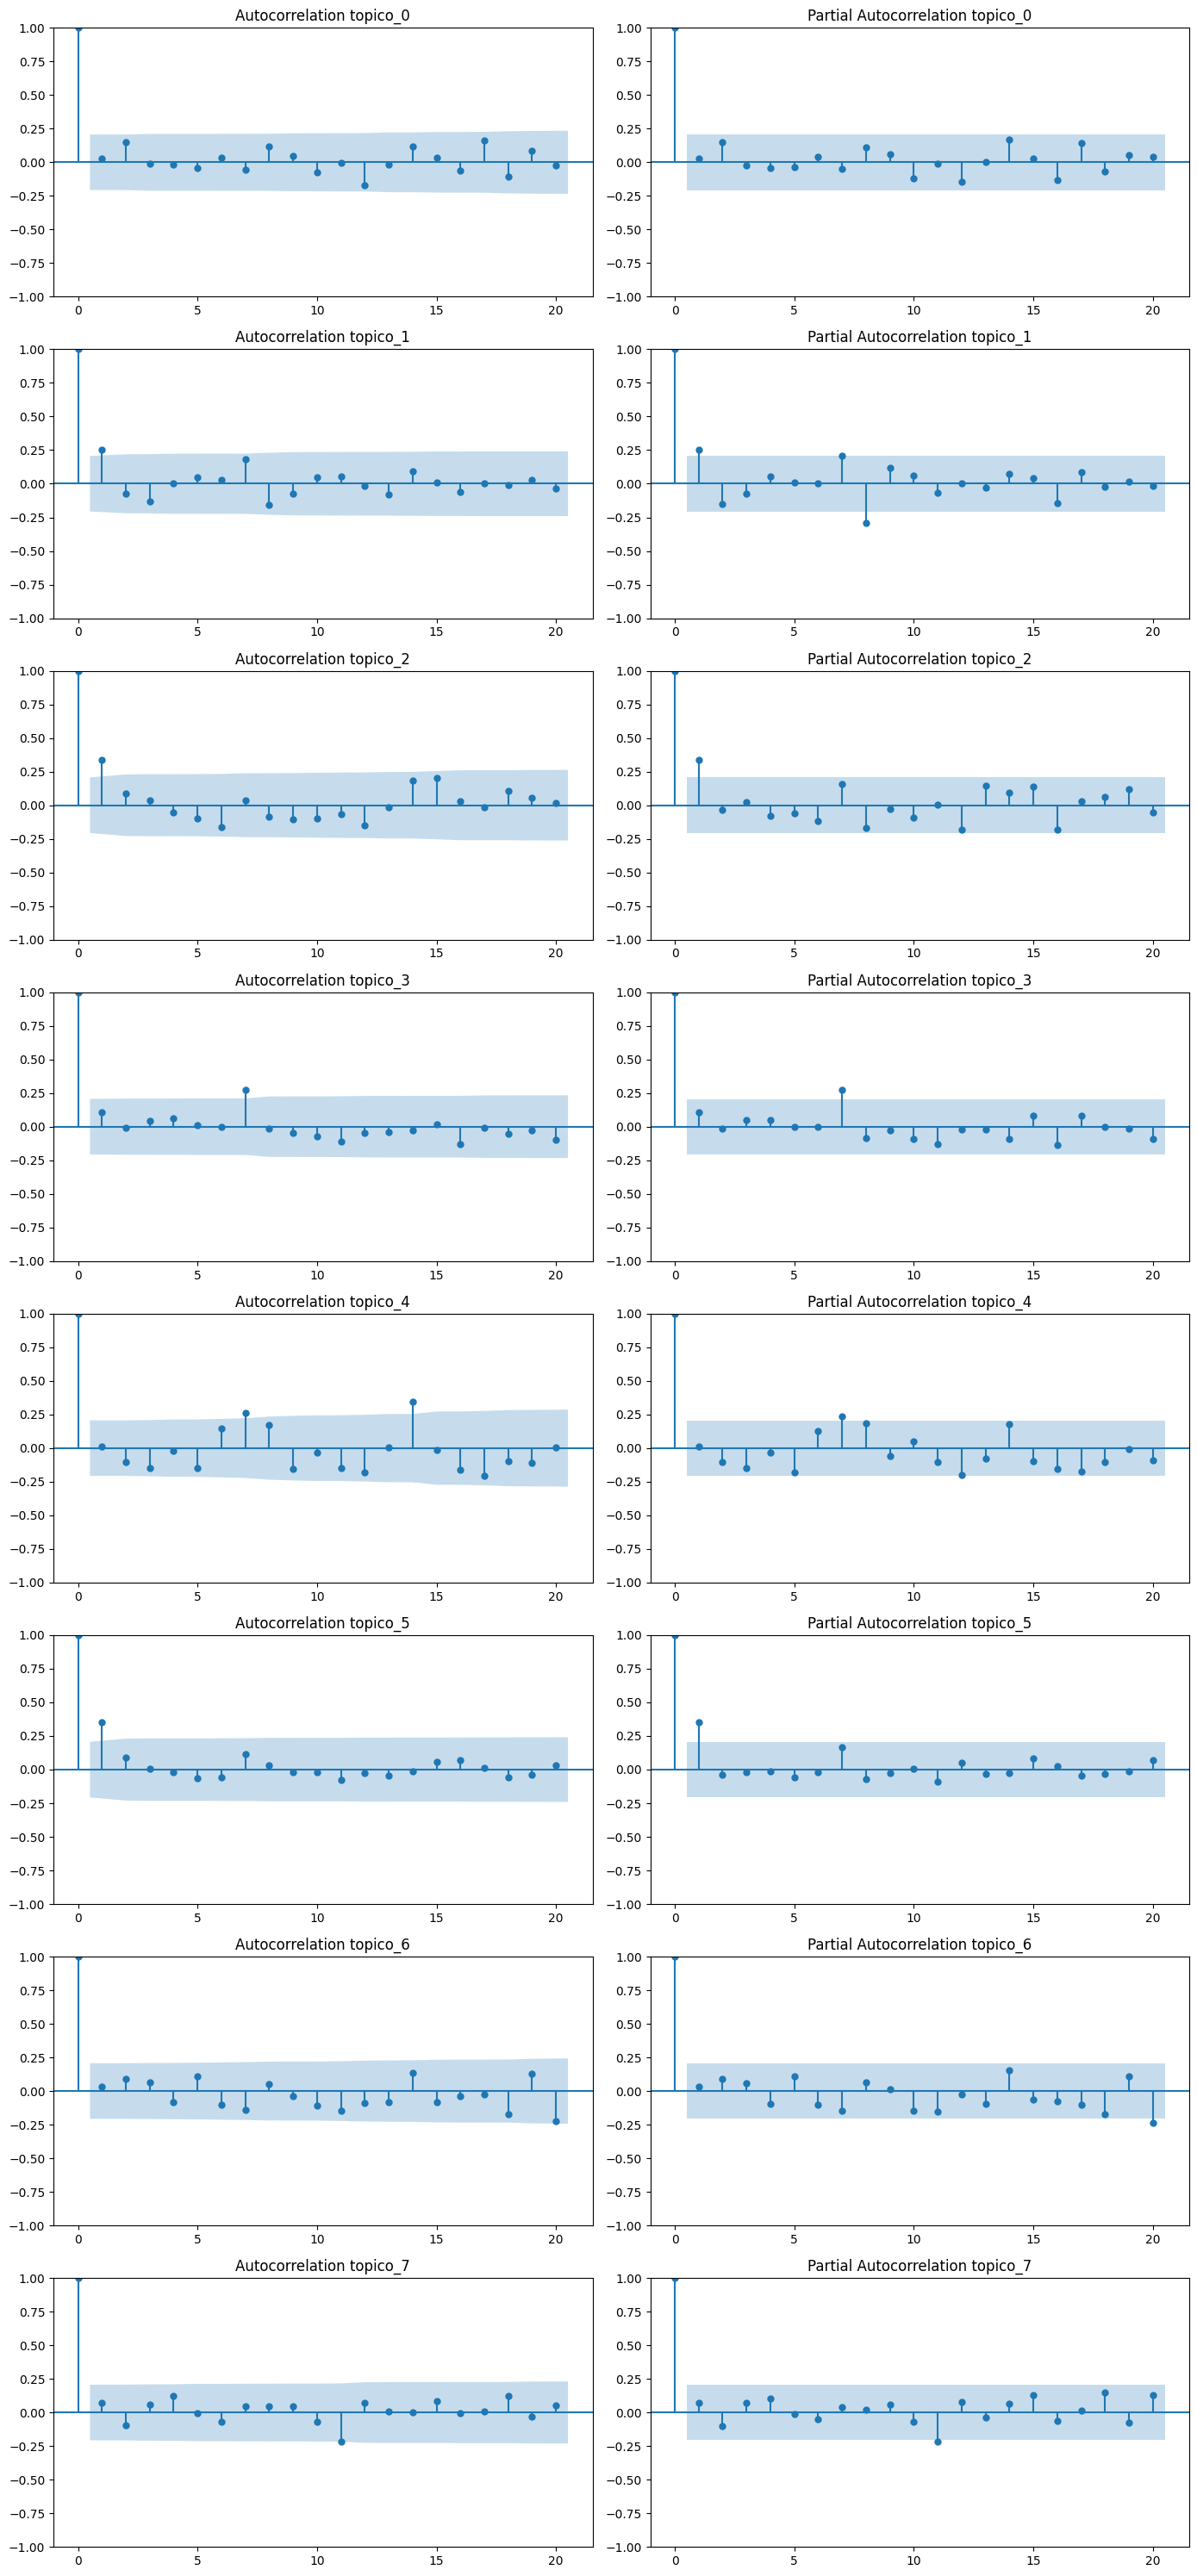

In [8]:
fig, axes = plt.subplots(8, 2, figsize=(14, 30))

for i, column in enumerate(df_series_temporales.columns):

    plot_acf(df_series_temporales[column], lags=20, ax=axes[i, 0], title=f'Autocorrelation {column}')
    plot_pacf(df_series_temporales[column], lags=20, ax=axes[i, 1], title=f'Partial Autocorrelation {column}')

plt.tight_layout()
plt.show()

### Análisis de estacionalidad

##### Tópico 4
Este es el único tópico que el test de Dickey-Fuller identificó como no estacionario con un p-value muy alto de 0.872. Esto indica que la serie debe ser tratada con diferenciación.

Al observar sus correlogramas (ACF/PACF), destaca un patrón de dependencia estacional significativa cada 7 y 14 días. Para capturar esta estructura, un suavizado exponencial simple no es suficiente.

##### Tópicos 1 y 3
Ambos tópicos presentan un p-value de 0.000 en el test ADF, lo que confirma que las series son estacionarias.

Sin embargo, al analizar sus correlogramas, observamos una estacionalidad clara cada 7 días en ambos casos.  Esto nos indica que su comportamiento parece estar regido por un ciclo semanal.

##### Resto de Tópicos (0, 2, 5, 6, 7)
Estos tópicos no parecen estacionarios, aunque algunos muestran una ligera influencia del día inmediatamente anterior (como el 2 y el 5), esto refleja una memoria muy corta y no una estructura cíclica que justifique un modelo estacional complejo.

## Analizamos tendencias en las series temporales.

#### Topico 1, 3 y 4 con tendencias de 7 días
Aplicamos seasonal decompose

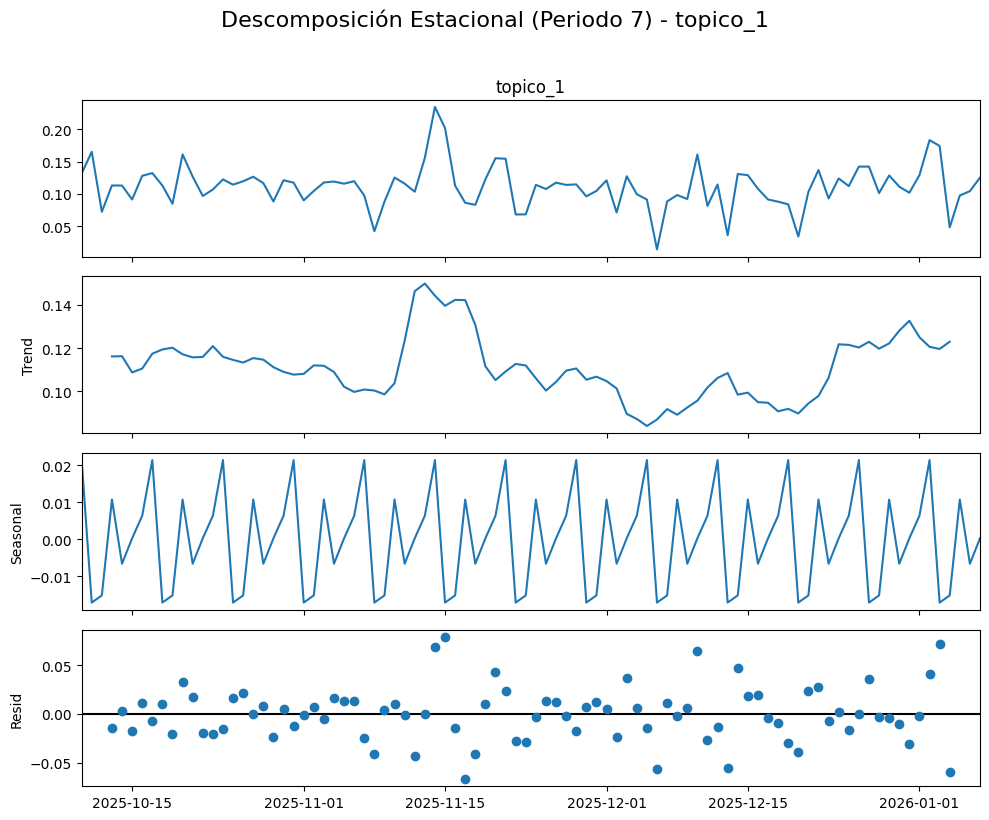

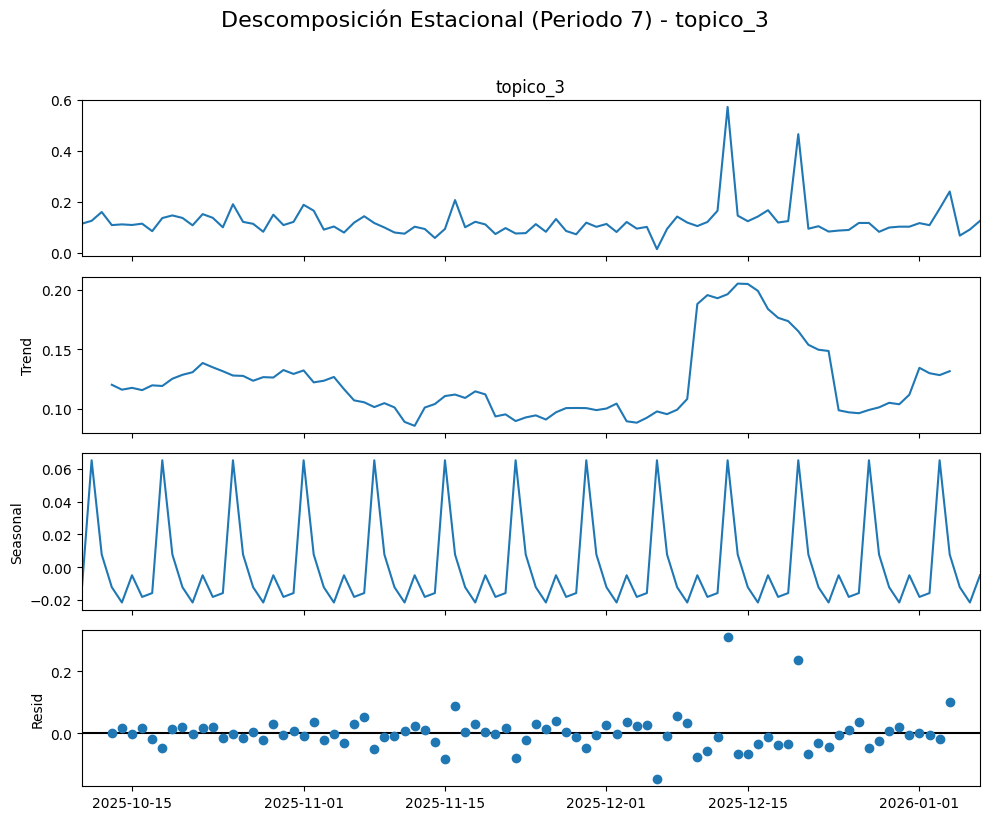

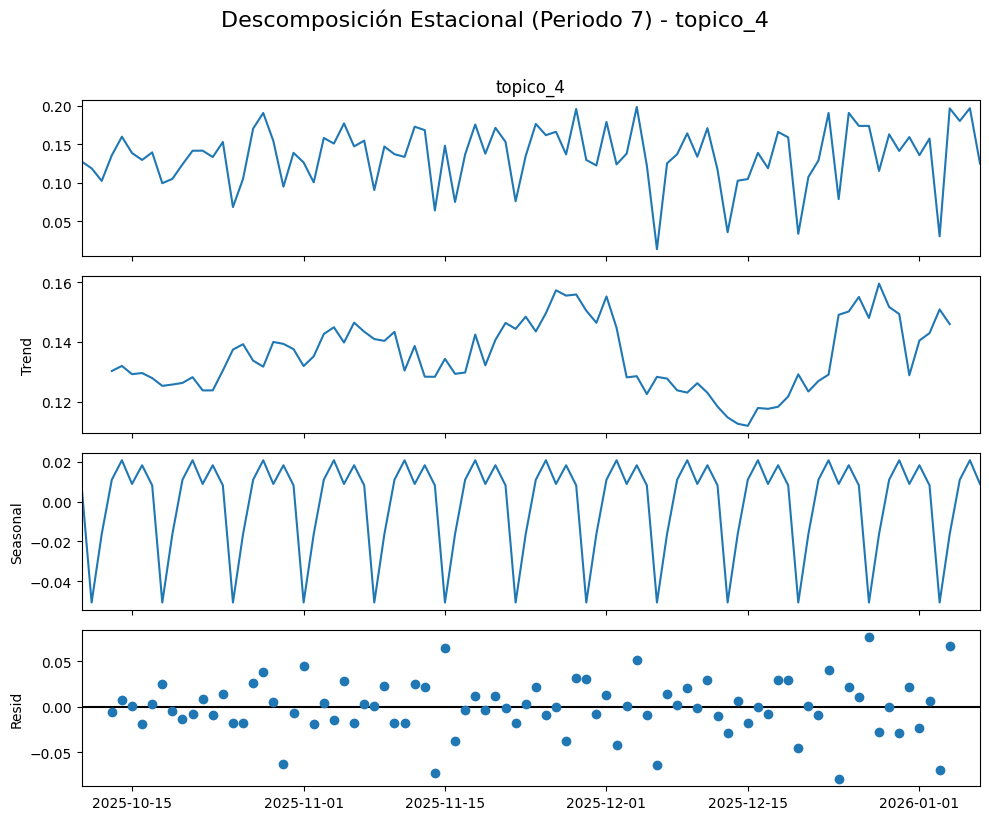

In [9]:
# Procesamos los tópicos que presentan patrones estacionales semanales (1, 3 y 4)
topicos_estacionales = ['topico_1', 'topico_3', 'topico_4']

for column in topicos_estacionales:
    if column in df_series_temporales.columns:
        series = df_series_temporales[column]
        
        # Descomposición Aditiva con periodo de 7 días
        # Se aplica a estos tópicos dado su claro componente cíclico semanal
        result = seasonal_decompose(series, model="additive", period=7)

        fig = result.plot()
        fig.set_size_inches(10, 8)
        fig.suptitle(f"Descomposición Estacional (Periodo 7) - {column}", fontsize=16, y=1.02)
        plt.tight_layout()
        plt.show()

#### Resto de topicos

Como no tienen estacionalidad, calculamos la media movil para buscar la tendencia

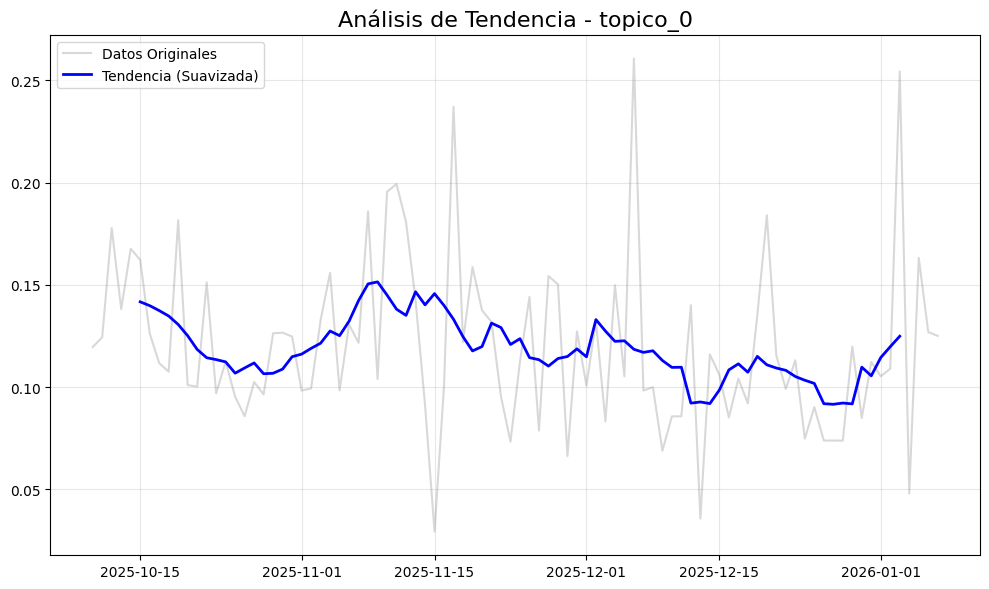

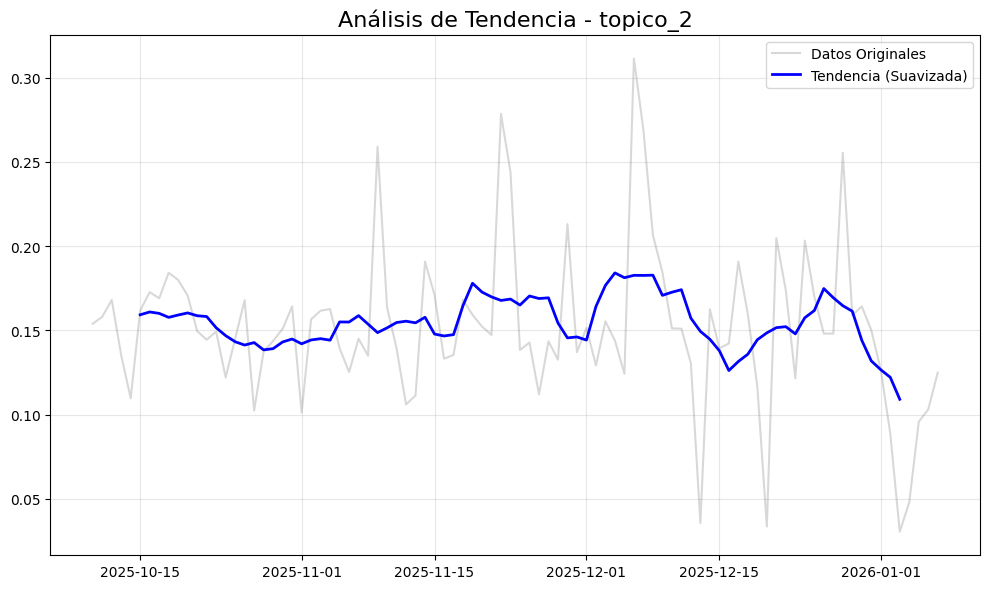

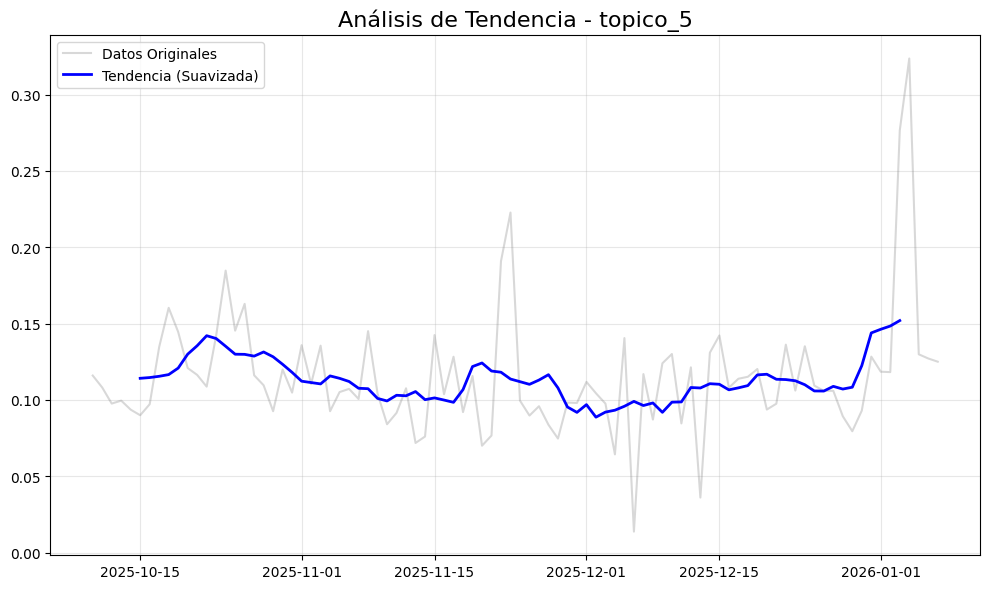

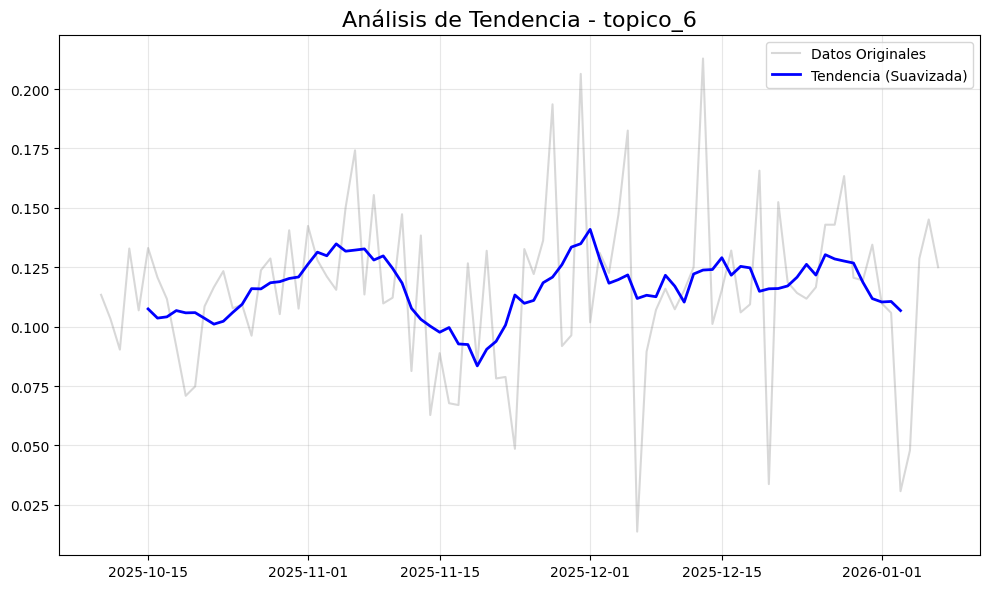

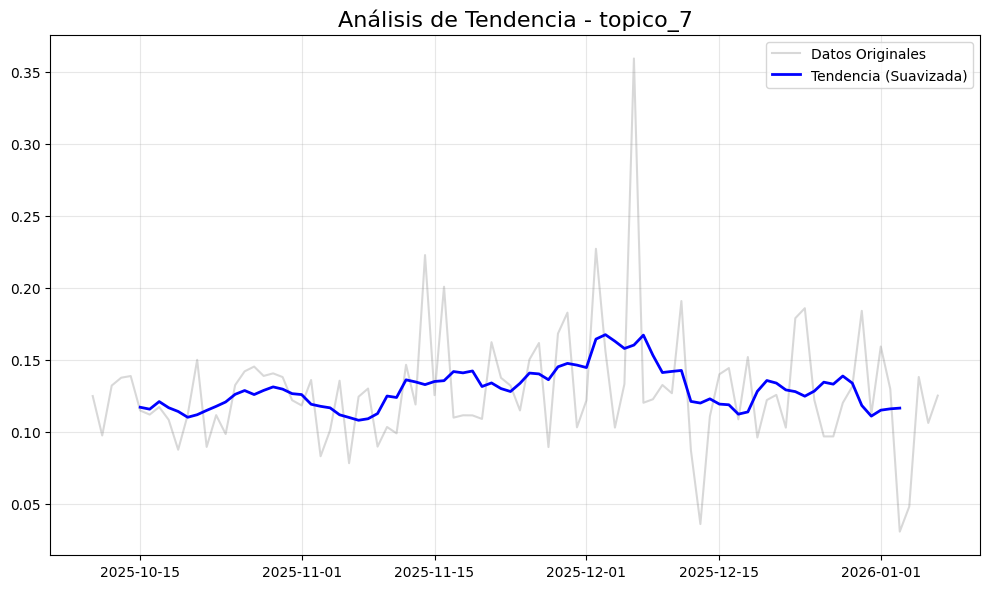

In [10]:
# Procesamos el resto de tópicos (aquellos sin estacionalidad definida)

# El resto de tópicos: Aquellos que no están en la lista de estacionales
topicos_simple = [c for c in df_series_temporales.columns if c not in topicos_estacionales]

for column in topicos_simple:
    series = df_series_temporales[column]
    
    # Calculamos TENDENCIA (Media móvil centrada para suavizar ruido)
    tendencia = series.rolling(window=10, center=True).mean()
    
    plt.figure(figsize=(10, 6))
    # Datos originales de fondo
    plt.plot(series, label='Datos Originales', alpha=0.3, color='gray')
    # Tendencia marcada
    plt.plot(tendencia, label='Tendencia (Suavizada)', color='blue', linewidth=2)
    
    plt.title(f"Análisis de Tendencia - {column}", fontsize=16)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

### Análisis de Tendencia

En lo referente a los **Tópicos 1 y 3**, la descomposición captura picos significativos de actividad (en noviembre para el Tópico 1 y diciembre para el Tópico 3), que se reflejan como subidas bruscas y aisladas en la tendencia. En el caso del Tópico 3, esto sugiere la presencia de una anomalía específica o un shock exógeno, respaldando la hipótesis planteada en el estudio: *"Las ofertas del sector logístico presentan mayor actividad en el inicio de diciembre, en preparación para la campaña navideña"*. Con respecto al Tópico 1 no podemos añadir información adicional sobre sus causas por que no hay nigún sector determinante ni plateamos ninguna hipótesis respeto a el. Descartando estos eventos puntuales, ninguna de las dos series muestra una tendencia significativa a largo plazo, retornando a sus niveles base tras los periodos de mayor actividad.

Respecto al **Tópico 4**, se observa una tendencia "nerviosa" que confirma la no estacionariedad estadística de la serie. Sin embargo, la tendencia oscila constantemente sin una dirección determinada y, por tanto, consideramos que no se detecta una tendencia sostenida de crecimiento o decrecimiento.

Finalmente, de carácter general, el **resto de tópicos (0, 2, 5, 6 y 7)** no presentan ninguna tendencia direccional a destacar. A diferencia de los casos anteriores, estos tópicos exhiben un comportamiento estacionario en media, oscilando alrededor de valores constantes con desviaciones similares entre sí. Aunque se observan picos puntuales de volatilidad, estos no se traducen en cambios estructurales y son considerados como ruido.

## Aplicación de suavizado exponencial 

#### Tópico 1, 3 y 4
Tópicos 1, 3 y 4 (Con Estacionalidad): Al tener un ciclo de 7 días, usaremos Holt-Winters (Triple Suavizado).

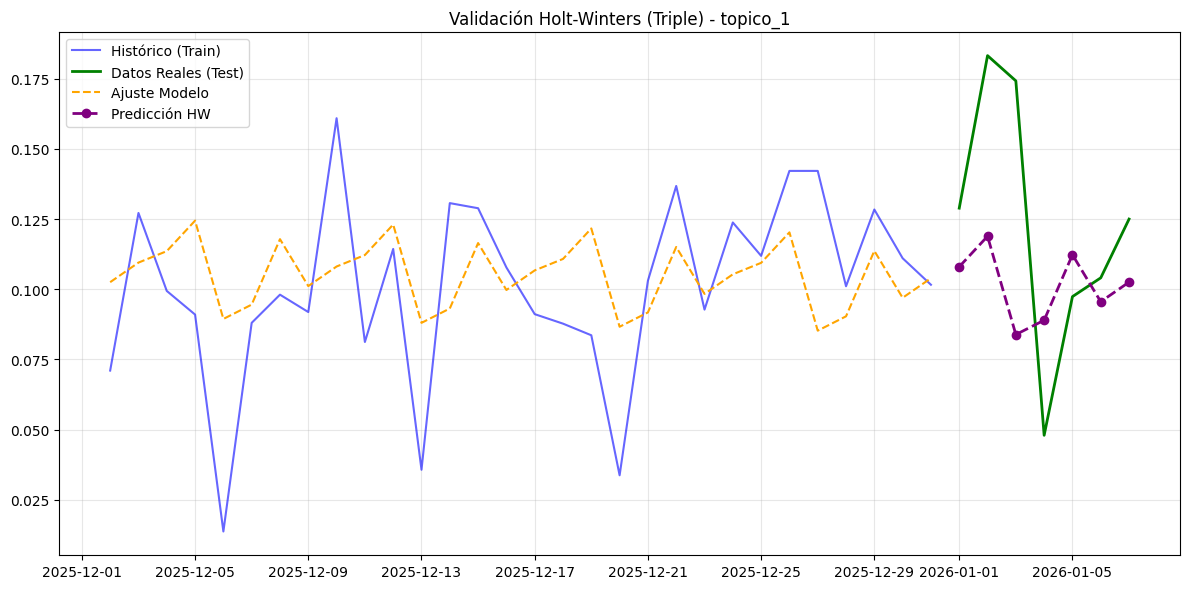

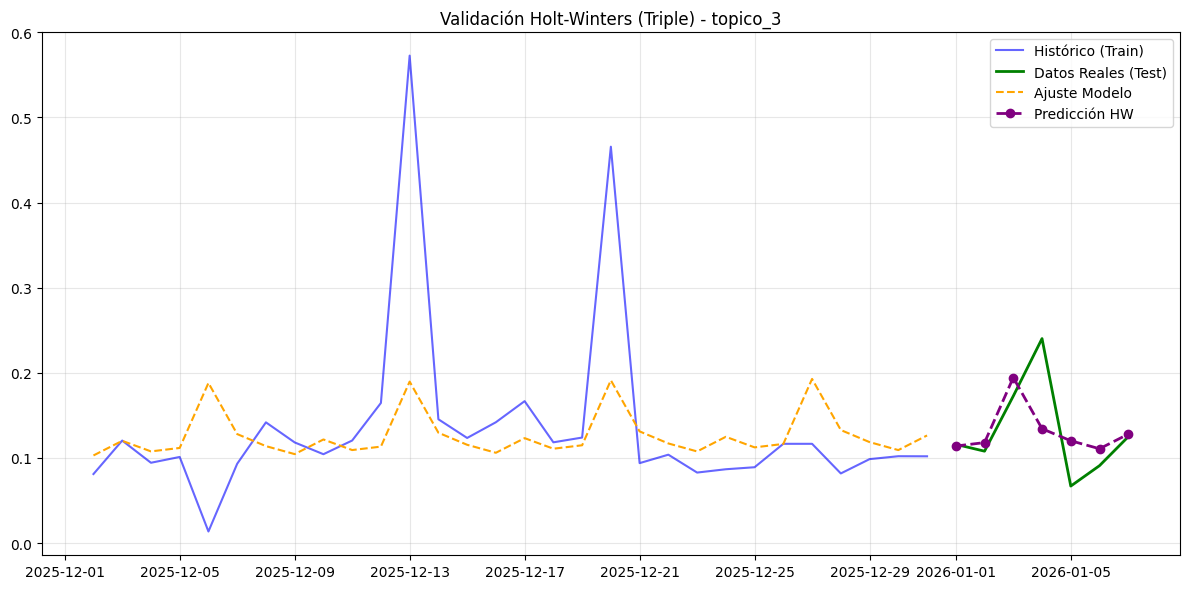

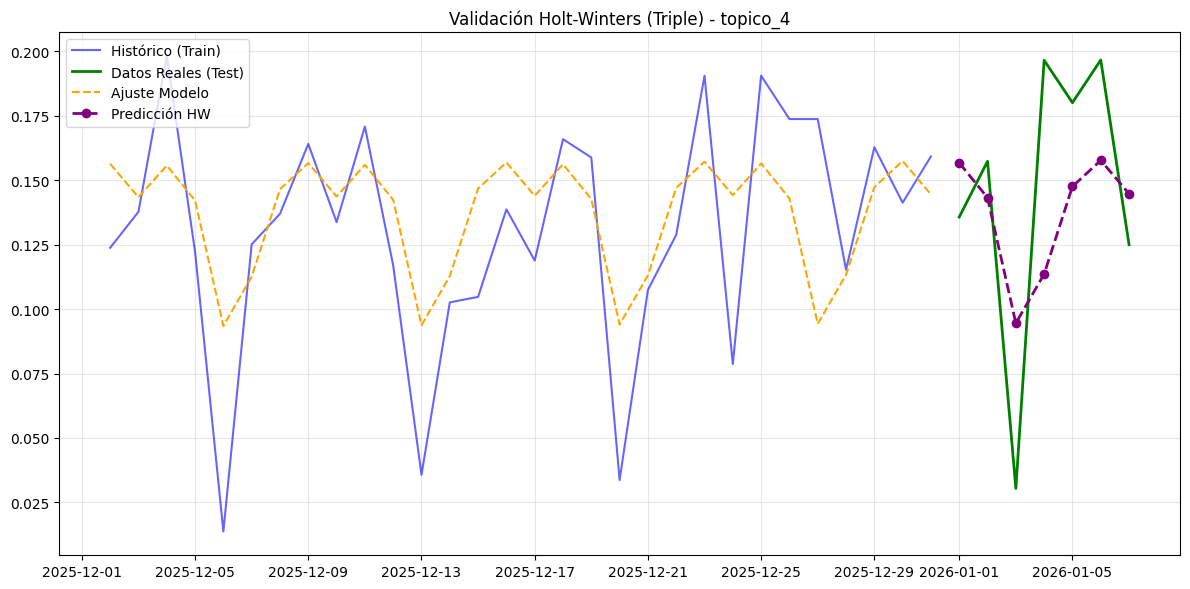

In [11]:
future_days = 7

for column in topicos_estacionales:
    if column in df_series_temporales.columns:
        series = df_series_temporales[column]
        
        # 1. Dividir en Train y Test
        # Usamos todos los datos menos los últimos 7 días para entrenar
        train_series = series[:-future_days]
        test_series = series[-future_days:]
        
        # 2. Modelo Holt-Winters (Triple Suavizado) sobre TRAIN
        # trend='add': Para capturar cambios en el nivel (tendencia local)
        # seasonal='add': Para modelar el ciclo semanal aditivo
        # seasonal_periods=7: Ciclo de 7 días
        model = ExponentialSmoothing(
            train_series, 
            trend='add', 
            seasonal='add', 
            seasonal_periods=7
        ).fit()
        
        # 3. Obtener valores ajustados (Train) y predicción (Test)
        fitted_values = model.fittedvalues
        forecast_values = model.forecast(future_days)
        
        # 4. Gráfico con el diseño solicitado
        plt.figure(figsize=(12, 6))
        
        # a) Datos Reales
        # Mostramos solo los últimos 30 días del train para hacer zoom en la zona de interés
        plt.plot(train_series.index[-30:], train_series.tail(30), label='Histórico (Train)', color='blue', alpha=0.6)
        plt.plot(test_series.index, test_series, label='Datos Reales (Test)', color='green', linewidth=2)
        
        # b) Modelo
        # Ajuste sobre los datos de entrenamiento
        plt.plot(fitted_values.index[-30:], fitted_values.tail(30), label='Ajuste Modelo', color='orange', linestyle='--')
        # Predicción sobre los datos de prueba
        plt.plot(forecast_values.index, forecast_values, label='Predicción HW', linestyle='--', marker='o', color='purple', linewidth=2)
        
        plt.title(f'Validación Holt-Winters (Triple) - {column}')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

#### Resto de tópicos
Resto de Tópicos (Sin Estacionalidad, Sin Tendencia): Al no tener componentes sistemáticos, usamos Suavizado Exponencial Simple, que simplemente estima filtrando el ruido.

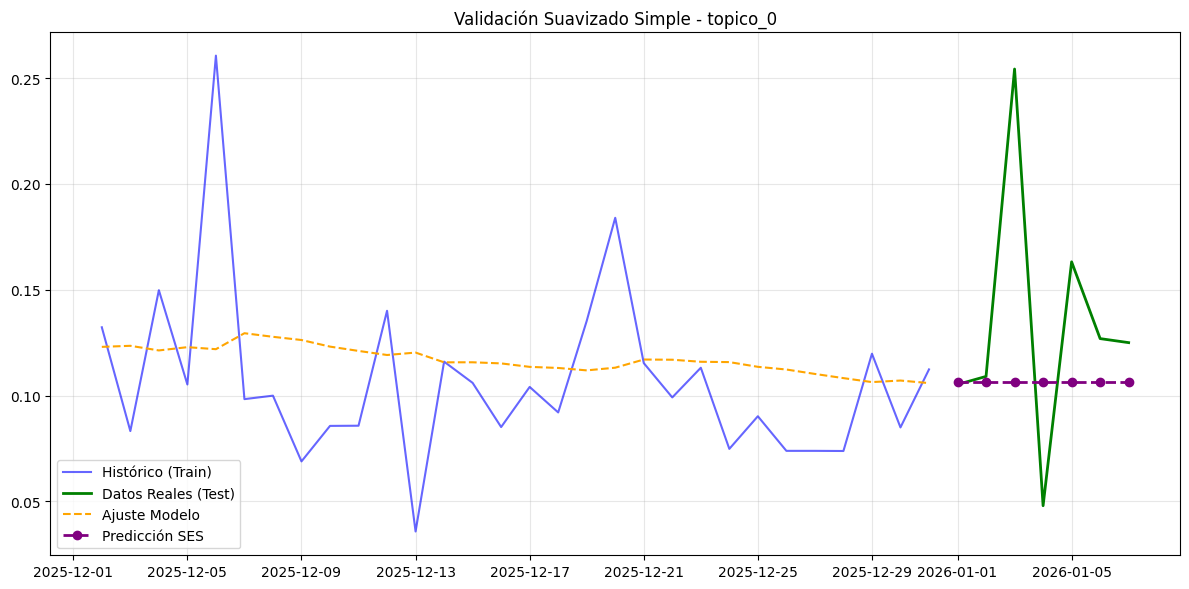

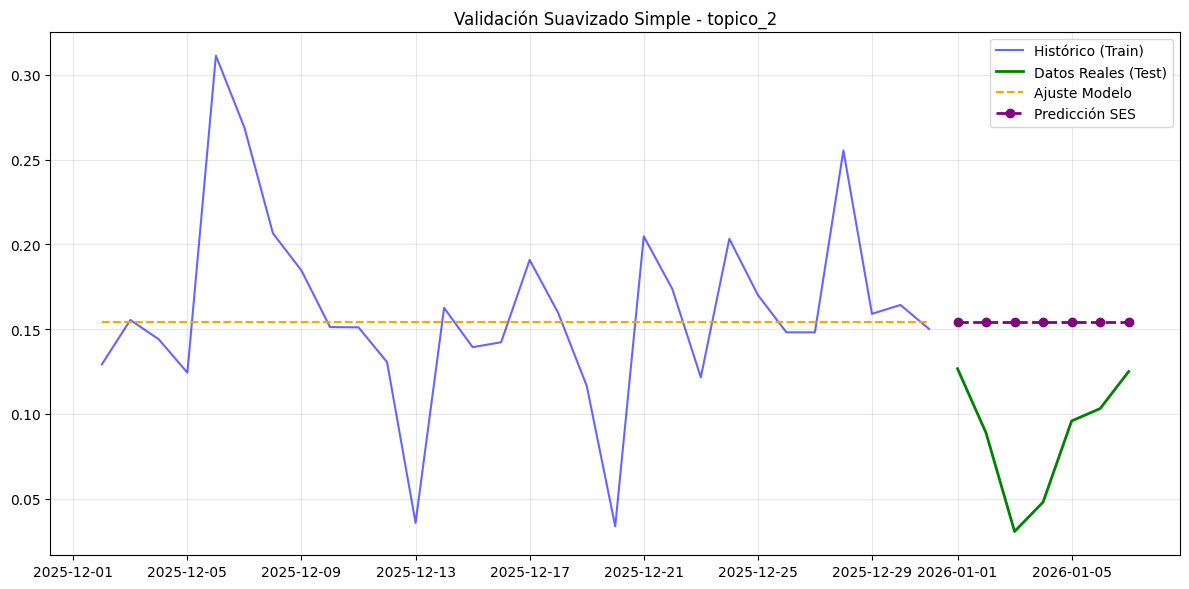

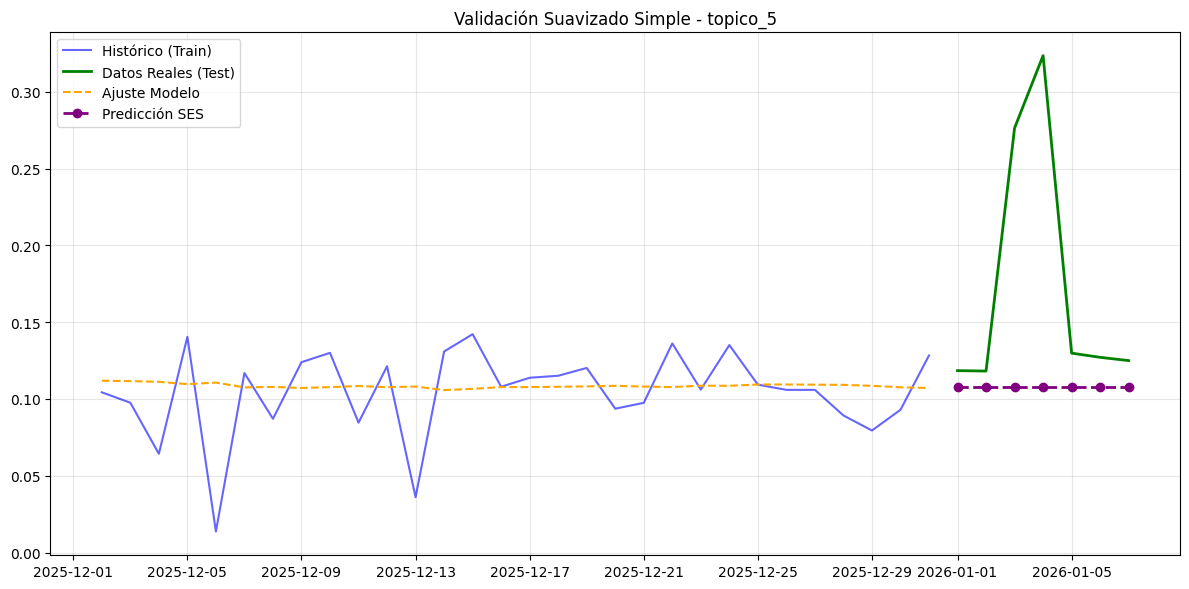

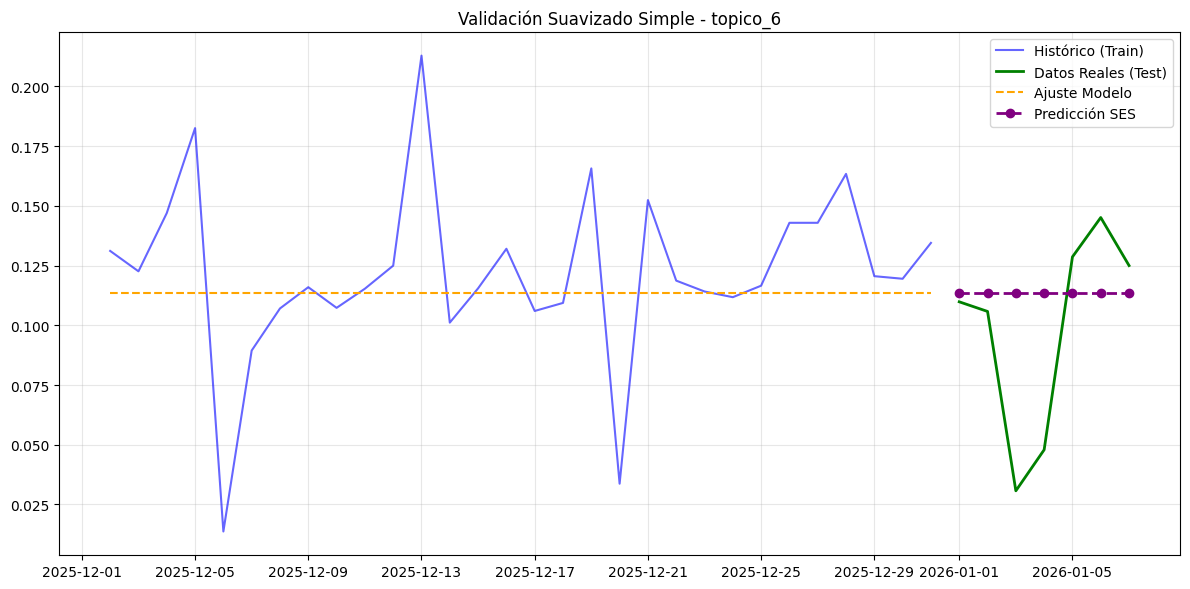

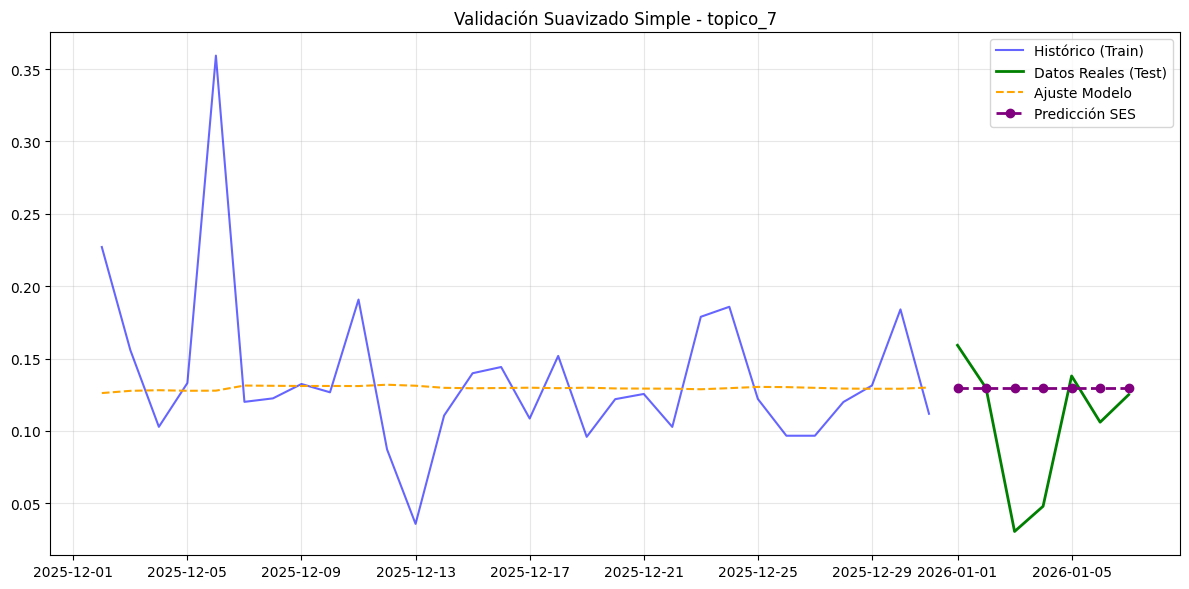

In [12]:
future_days = 7

for column in topicos_simple:
    series = df_series_temporales[column]
    
    # 1. Dividir en Train y Test
    train_series = series[:-future_days]
    test_series = series[-future_days:]
    
    # 2. Modelo Suavizado Simple (SES) sobre TRAIN
    # Asume nivel constante (sin tendencia ni estacionalidad)
    model = SimpleExpSmoothing(train_series).fit()
    
    # 3. Obtener valores ajustados y predicción
    fitted_values = model.fittedvalues
    forecast_values = model.forecast(future_days)
    
    # 4. Gráfico
    plt.figure(figsize=(12, 6))
    
    # a) Datos Reales
    plt.plot(train_series.index[-30:], train_series.tail(30), label='Histórico (Train)', color='blue', alpha=0.6)
    plt.plot(test_series.index, test_series, label='Datos Reales (Test)', color='green', linewidth=2)
    
    # b) Modelo
    plt.plot(fitted_values.index[-30:], fitted_values.tail(30), label='Ajuste Modelo', color='orange', linestyle='--')
    plt.plot(forecast_values.index, forecast_values, label='Predicción SES', linestyle='--', marker='o', color='purple', linewidth=2)
    
    plt.title(f'Validación Suavizado Simple - {column}')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

### Análisis Suavizado exponencial

Para los **Tópicos 1, 3 y 4**, al aplicar el modelo de triple suavizado (Holt-Winters), el modelo logra capturar correctamente la fase del ciclo (acierta en las subidas y bajadas semanales), vuelve a corroborar la estacionalidad de 7 días. Sin embargo, la predicción no es perfecta en cuanto a magnitud por que el modelo tiende a ser conservador y el componente aleatorio tiene un peso muy significativo que cuesta predecir con exactitud. 

Para el **resto de tópicos (0, 2, 5, 6 y 7)**, la aplicación del Suavizado Exponencial Simple arroja una predicción plana. Este resultado tiene sentido ya que al no considerar ni tendencia ni estacionalidad, el modelo determina que la mejor predicción posible es el nivel medio actual. La gran diferencia entre la predicción y los datos reales ilustra un nivel de ruido muy intenso, lo que nos puede dar a pensar que existe alguna influencia exogenea en las series. 

## Aplicación SARIMA

Los tópicos estacionales son siempre cada 7 dias, por tanto el valor estacional es siempre 7. Para todos los topicos salvo el 4 (donde d=1), el valor de d=0 ya que no requiere diferenciación para lograr ser estacionaria.

Para determinar los parámetros óptimos (p, q, P, Q) de cada modelo, hemos implementado una Grid Search que evalúa múltiples combinaciones respetando las restricciones de integración y estacionalidad de cada tópico.

La selección del mejor modelo se ha basado en minimizar el Criterio de Información de Akaike (AIC). Hemos preferido el AIC sobre el BIC porque nuestro objetivo es maximizar la capacidad predictiva a corto plazo. El AIC estima mejor el error de predicción futuro y evita el riesgo de seleccionar modelos demasiado simples que el BIC podría favorecer al penalizar, además nuestra muestra no es demasido densa y el BIC tiende a tener mejor desempeño cuando la muestra es grande, para evitar el sobreajuste.


In [13]:
import itertools
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings

# Función para buscar los mejores parámetros p, q (y P, Q) dado un d, D, s fijos
def grid_search_sarima(series, d, D, s, seasonal=True):
    p = q = range(0, 6)
    if seasonal:
        P = Q = range(0, 2) # P y Q estacionales suelen ser bajos 
        # Generamos combinaciones: (p, d, q) x (P, D, Q, s)
        pdq = [(x[0], d, x[1]) for x in list(itertools.product(p, q))]
        seasonal_pdq = [(x[0], D, x[1], s) for x in list(itertools.product(P, Q))]
        combinations = list(itertools.product(pdq, seasonal_pdq))
    else:
        # Solo (p, d, q)
        combinations = [(x[0], d, x[1]) for x in list(itertools.product(p, q))]
        seasonal_pdq = [(0, 0, 0, 0)] 

    best_aic = float("inf")
    best_order = None
    best_seasonal_order = None
    best_model = None

    print(f"Buscando mejores parámetros para d={d}, D={D}, s={s}...")
    
    warnings.filterwarnings("ignore") # Ignorar warnings de convergencia

    for param in combinations:
        try:
            if seasonal:
                order = param[0]
                seasonal_order = param[1]
            else:
                order = param
                seasonal_order = (0, 0, 0, 0)

            model = SARIMAX(series,
                            order=order,
                            seasonal_order=seasonal_order,
                            enforce_stationarity=False,
                            enforce_invertibility=False)
            
            results = model.fit(disp=False)
            
            if results.aic < best_aic:
                best_aic = results.aic
                best_order = order
                best_seasonal_order = seasonal_order
                best_model = results
                
        except:
            continue
            
    print(f"  -> Mejor AIC: {best_aic:.2f} | Order: {best_order} | Seasonal: {best_seasonal_order}")
    return best_model, best_order, best_seasonal_order

topico 4

Buscando mejores parámetros para d=1, D=1, s=7...
  -> Mejor AIC: -245.32 | Order: (1, 1, 1) | Seasonal: (0, 1, 0, 7)


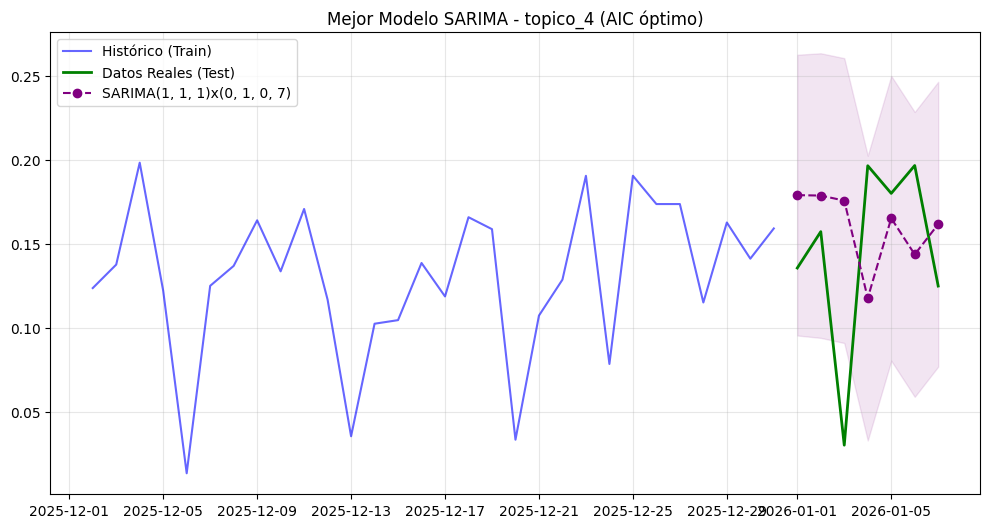

In [14]:
nombre_topico = 'topico_4'
series = df_series_temporales[nombre_topico]
future_days = 7

# Train/Test
train = series[:-future_days]
test = series[-future_days:]

# Grid Search con d=1, D=1, s=7
best_model, order, seasonal_order = grid_search_sarima(train, d=1, D=1, s=7, seasonal=True)

# Predicción
forecast = best_model.get_forecast(steps=future_days)
pred_mean = forecast.predicted_mean
pred_ci = forecast.conf_int()

# Gráfico
plt.figure(figsize=(12, 6))
plt.plot(train.index[-30:], train.tail(30), label='Histórico (Train)', color='blue', alpha=0.6)
plt.plot(test.index, test, label='Datos Reales (Test)', color='green', linewidth=2)
plt.plot(pred_mean.index, pred_mean, label=f'SARIMA{order}x{seasonal_order}', color='purple', marker='o', linestyle='--')
plt.fill_between(pred_ci.index, pred_ci.iloc[:, 0], pred_ci.iloc[:, 1], color='purple', alpha=0.1)
plt.title(f'Mejor Modelo SARIMA - {nombre_topico} (AIC óptimo)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

Topicos 1 y 3


--- Analizando topico_1 ---
Buscando mejores parámetros para d=0, D=1, s=7...
  -> Mejor AIC: -274.43 | Order: (2, 0, 0) | Seasonal: (0, 1, 0, 7)


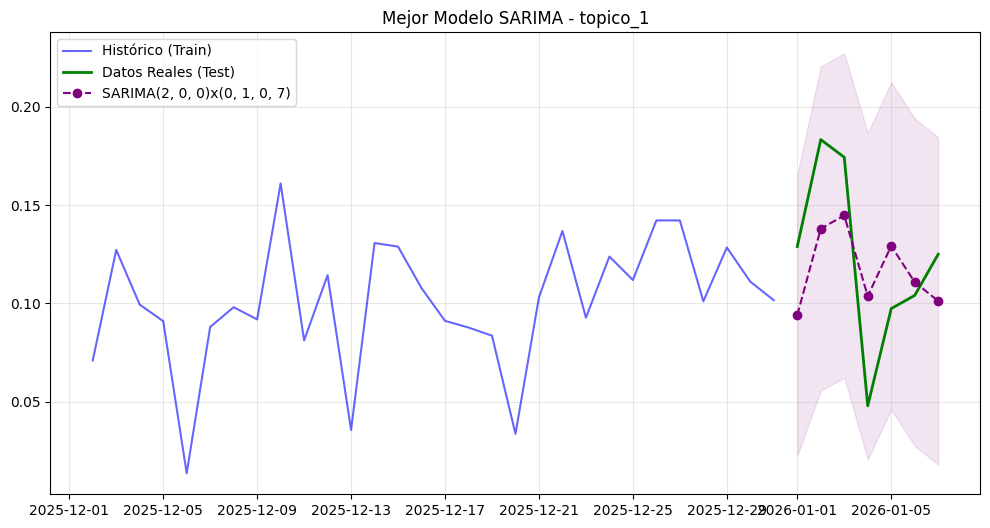


--- Analizando topico_3 ---
Buscando mejores parámetros para d=0, D=1, s=7...
  -> Mejor AIC: -151.91 | Order: (1, 0, 0) | Seasonal: (0, 1, 0, 7)


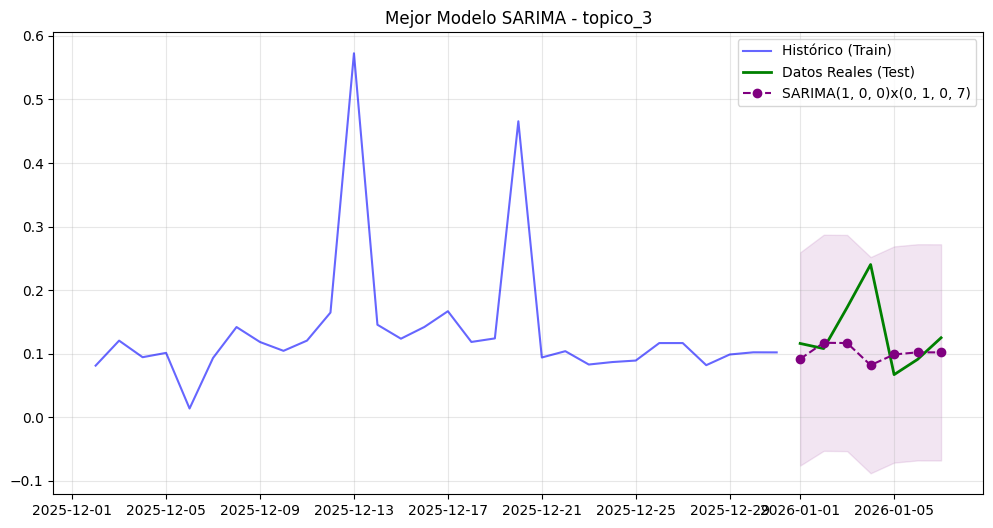

In [15]:
topicos_estacionales_st = ['topico_1', 'topico_3']

for nombre_topico in topicos_estacionales_st:
    if nombre_topico in df_series_temporales.columns:
        series = df_series_temporales[nombre_topico]
        train = series[:-future_days]
        test = series[-future_days:]
        
        print(f"\n--- Analizando {nombre_topico} ---")
        # Grid Search con d=0, D=1, s=7
        best_model, order, seasonal_order = grid_search_sarima(train, d=0, D=1, s=7, seasonal=True)
        
        forecast = best_model.get_forecast(steps=future_days)
        pred_mean = forecast.predicted_mean
        pred_ci = forecast.conf_int()
        
        plt.figure(figsize=(12, 6))
        plt.plot(train.index[-30:], train.tail(30), label='Histórico (Train)', color='blue', alpha=0.6)
        plt.plot(test.index, test, label='Datos Reales (Test)', color='green', linewidth=2)
        plt.plot(pred_mean.index, pred_mean, label=f'SARIMA{order}x{seasonal_order}', color='purple', marker='o', linestyle='--')
        plt.fill_between(pred_ci.index, pred_ci.iloc[:, 0], pred_ci.iloc[:, 1], color='purple', alpha=0.1)
        plt.title(f'Mejor Modelo SARIMA - {nombre_topico}')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()

Resto de topicos (ARIMA Simple)


--- Analizando topico_0 ---
Buscando mejores parámetros para d=0, D=0, s=0...
  -> Mejor AIC: -287.10 | Order: (1, 0, 1) | Seasonal: (0, 0, 0, 0)


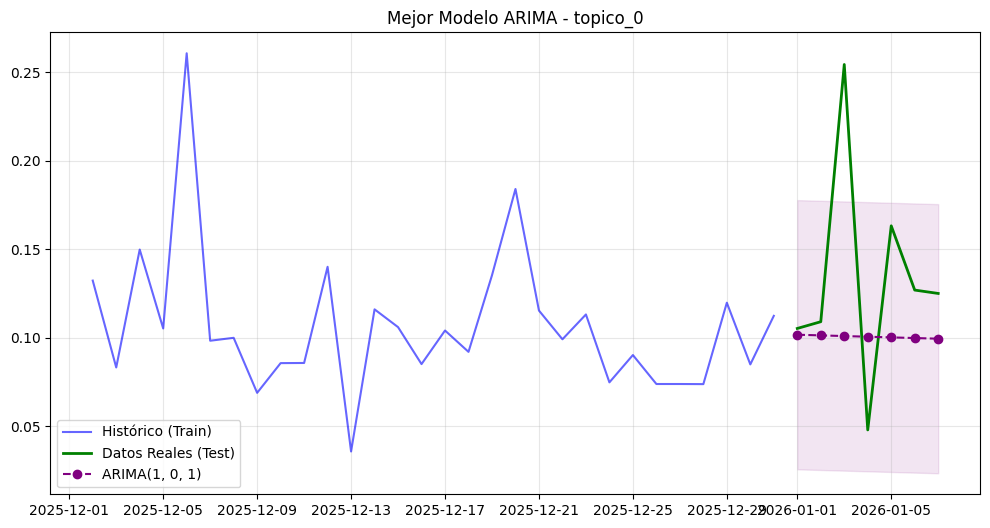


--- Analizando topico_2 ---
Buscando mejores parámetros para d=0, D=0, s=0...
  -> Mejor AIC: -268.86 | Order: (2, 0, 1) | Seasonal: (0, 0, 0, 0)


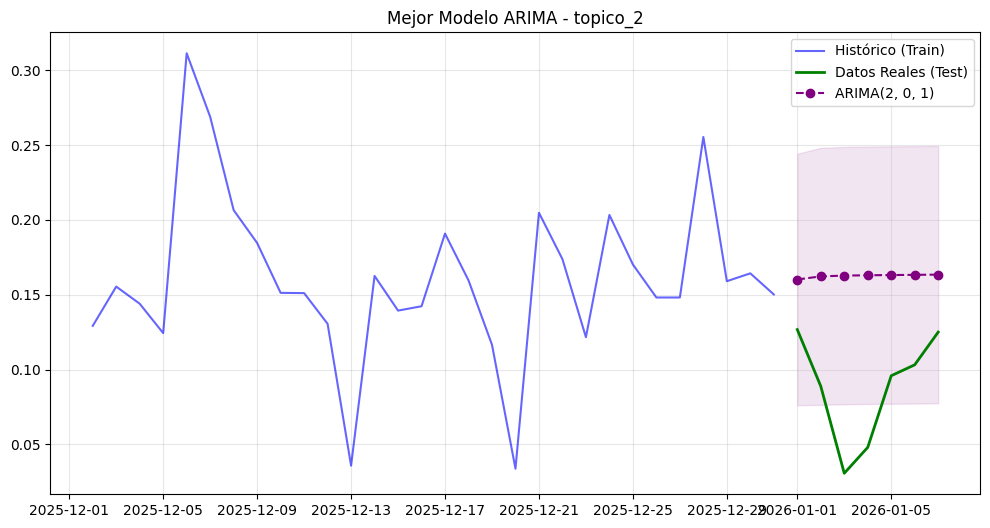


--- Analizando topico_5 ---
Buscando mejores parámetros para d=0, D=0, s=0...
  -> Mejor AIC: -327.78 | Order: (1, 0, 1) | Seasonal: (0, 0, 0, 0)


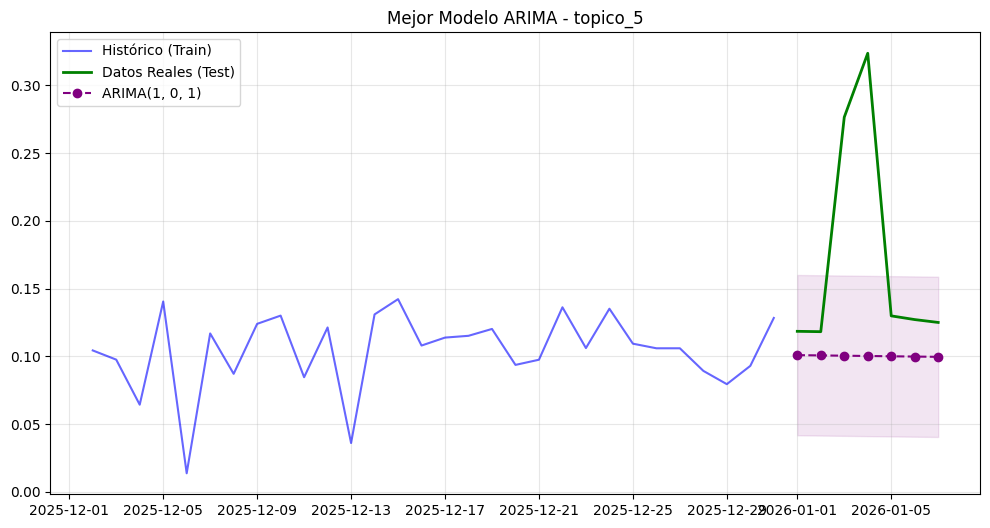


--- Analizando topico_6 ---
Buscando mejores parámetros para d=0, D=0, s=0...
  -> Mejor AIC: -310.56 | Order: (1, 0, 1) | Seasonal: (0, 0, 0, 0)


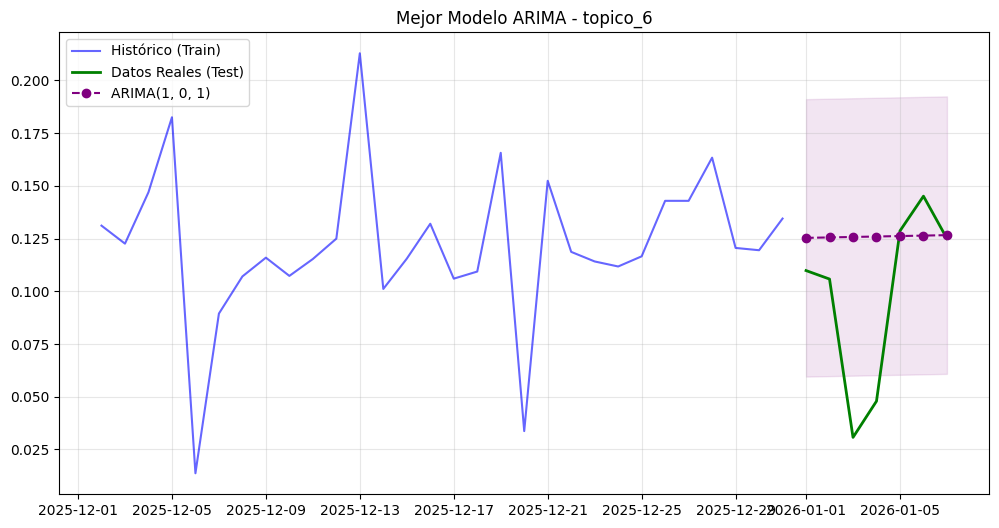


--- Analizando topico_7 ---
Buscando mejores parámetros para d=0, D=0, s=0...
  -> Mejor AIC: -278.82 | Order: (1, 0, 1) | Seasonal: (0, 0, 0, 0)


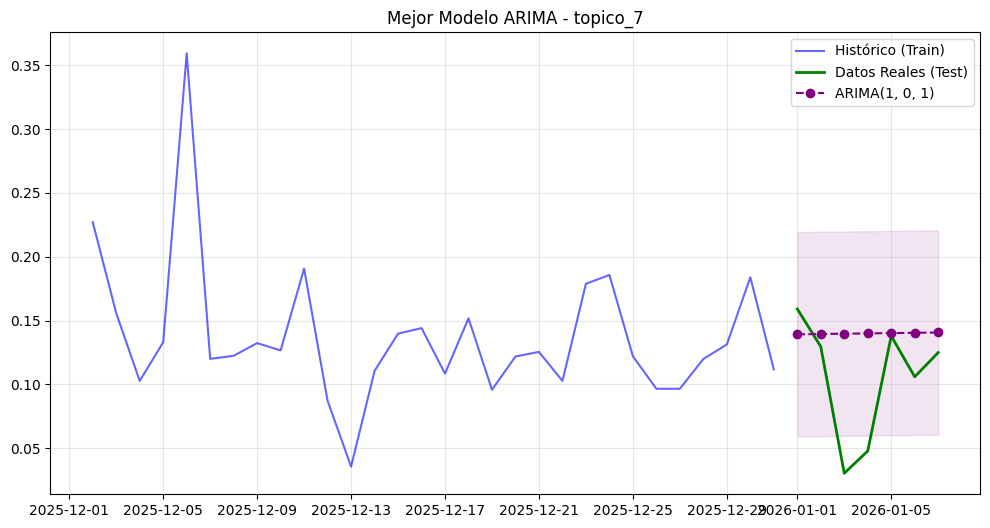

In [16]:
topicos_especiales = ['topico_4', 'topico_1', 'topico_3']
topicos_ruido = [c for c in df_series_temporales.columns if c not in topicos_especiales]

for nombre_topico in topicos_ruido:
    series = df_series_temporales[nombre_topico]
    train = series[:-future_days]
    test = series[-future_days:]
    
    print(f"\n--- Analizando {nombre_topico} ---")
    # Grid Search con d=0, D=0, s=0 (Modelo ARIMA simple)
    best_model, order, _ = grid_search_sarima(train, d=0, D=0, s=0, seasonal=False)
    
    forecast = best_model.get_forecast(steps=future_days)
    pred_mean = forecast.predicted_mean
    pred_ci = forecast.conf_int()
    
    plt.figure(figsize=(12, 6))
    plt.plot(train.index[-30:], train.tail(30), label='Histórico (Train)', color='blue', alpha=0.6)
    plt.plot(test.index, test, label='Datos Reales (Test)', color='green', linewidth=2)
    plt.plot(pred_mean.index, pred_mean, label=f'ARIMA{order}', color='purple', marker='o', linestyle='--')
    plt.fill_between(pred_ci.index, pred_ci.iloc[:, 0], pred_ci.iloc[:, 1], color='purple', alpha=0.1)
    plt.title(f'Mejor Modelo ARIMA - {nombre_topico}')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

### Análisis SARIMA

#### Tópico 4
El modelo SARIMA seleccionado `(1, 1, 1)x(0, 1, 0, 7)` arroja resultados muy similares a los obtenidos previamente con el suavizado exponencial. Aunque el modelo identifica la periodicidad y la dirección de los cambios, **falla sistemáticamente en capturar la magnitud de la volatilidad**, como sucedía con el Holt-Winters. La predicción incapaz de alcanzar los picos extremos de la serie real. Esto evidencia que la complejidad adicional del modelo SARIMA no aporta una ventaja frente al suavizado exponencial en nuestro caso, ya que el componente de ruido  es tan dominante que limita la precisión de cualquier modelo.

#### Tópicos 1 y 3
De manera análoga, los modelos SARIMA para los Tópicos 1 y 3 muestran las mismas limitaciones que sus contrapartes de suavizado, solo se detecta una pequeña mejora en el tópico 1. Capturan el ciclo base, pero se ven desbordados por la variabilidad de la serie.

A pesar de los picos exógenos observados (noviembre/diciembre), hemos decidido no utilizar modelos SARIMAX, ya que estos eventos puntuales (campaña navideña y Black Friday) introducen unos valores que no responden con la dinámica interna de la serie. Podemos respaldar que la dificultad de predicción no es un fallo en los modelos, sino una característica intrínseca de series que no se puede modelar ya que están afectadas por eventos de alto impacto.


## SARIMAX

In [17]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Lista de columnas que representan los sectores (tú defines esta lista)
sectores = [i for i in df.columns if i not in columnas_excluir and "topico" not in i and "sentimiento" not in i]
print(sectores)

# Función de agrupación (como la que ya usas)
def agrupar(df, columna, freq="D"):
    return df.groupby(pd.Grouper(key="timestamp", freq=freq))[columna].mean()

# Construir X con las series agrupadas
X = pd.DataFrame()

for sector in sectores:
    series_diaria = agrupar(df, sector, freq="D")
    X[sector] = series_diaria

# Aseguramos que el índice temporal esté alineado
X = X.fillna(0)


model = SARIMAX(
    endog=df_series_temporales["topico_4"],
    exog=X,                   # variables exógenas 
    order=(1, 1, 1),            # parte no estacional
    seasonal_order=(0, 1, 0, 7)  # parte estacional
)

results = model.fit()
print(results.summary())


['Hostelería y Turismo', 'Sanitario y Salud', 'Educación y Formación', 'Tecnología y Telecomunicaciones', 'Construcción e Inmobiliaria', 'Industria y Manufactura', 'Comercio y Ventas', 'Logística y Transporte', 'Administración y Finanzas', 'Cultura, Arte y Ocio']
                                     SARIMAX Results                                      
Dep. Variable:                           topico_4   No. Observations:                   90
Model:             SARIMAX(1, 1, 1)x(0, 1, [], 7)   Log Likelihood                 158.817
Date:                            Thu, 04 Dec 2025   AIC                           -291.635
Time:                                    14:33:31   BIC                           -260.347
Sample:                                10-10-2025   HQIC                          -279.073
                                     - 01-07-2026                                         
Covariance Type:                              opg                                         
        

## Modelado con LSTM para la serie temporal

Además de los modelos clásicos (suavizado exponencial, SARIMA y SARIMAX), hemos incorporado un modelo de **red neuronal LSTM** (*Long Short-Term Memory*) para cada tópico, con tres objetivos principales:

1. Aprender la dinámica temporal de cada serie.
2. Detectar **anomalías** a partir del error de predicción.
3. Generar **predicciones futuras** a corto plazo.

Todo el proceso se aplica de forma sistemática a los 8 tópicos:


In [ ]:
TOPICOS = [f"topico_{i}" for i in range(8)] 


================= topico_0 =================


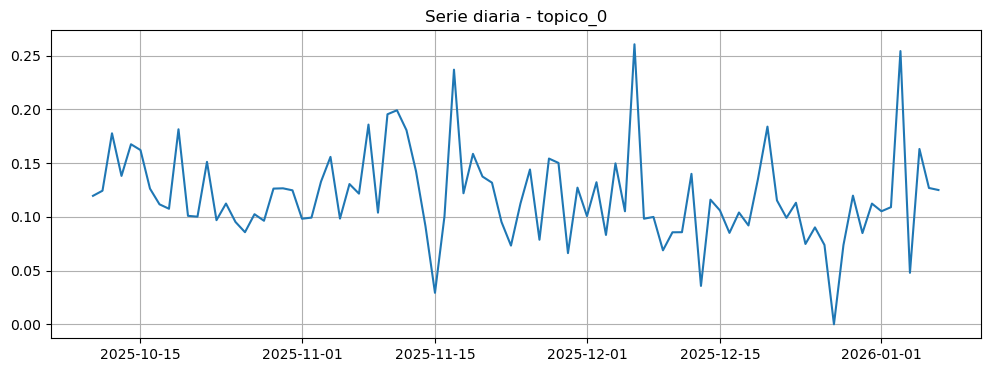

X shape: (83, 7, 1)
y shape: (83,)
Train: (66, 7, 1) (66,)
Test : (17, 7, 1) (17,)


c:\Users\alexi\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_15 (LSTM)                  │ (None, 100)            │        40,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 40,901 (159.77 KB)

 Trainable params: 40,901 (159.77 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 174ms/step - loss: 0.2262 - val_loss: 0.1561
Epoch 2/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.1793 - val_loss: 0.1202
Epoch 3/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.1243 - val_loss: 0.0865
Epoch 4/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0886 - val_loss: 0.0577
Epoch 5/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0472 - val_loss: 0.0433
Epoch 6/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0273 - val_loss: 0.0512
Epoch 7/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0281 - val_loss: 0.0528
Epoch 8/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0286 - val_loss: 0.0439
Epoch 9/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0274 - val_loss: 0.0426
Epoch 10/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0326 - val_loss: 0.0428
Epoch 11/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.0290 - val_loss: 0.0425
Epoch 12/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0246 - val_loss: 0.0436


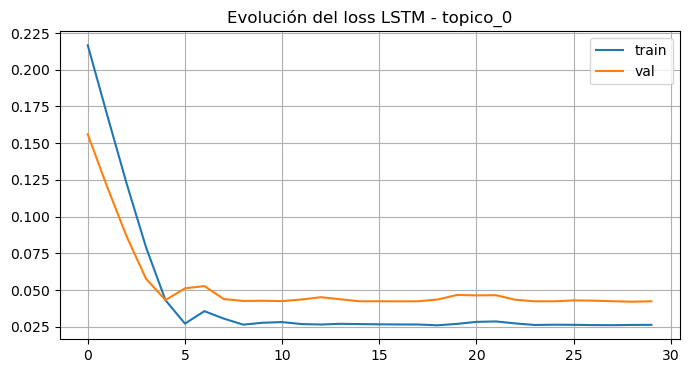

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 172ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
LSTM topico_0 - Train -> RMSE: 0.04, MAE: 0.03
LSTM topico_0 - Test  -> RMSE: 0.05, MAE: 0.04


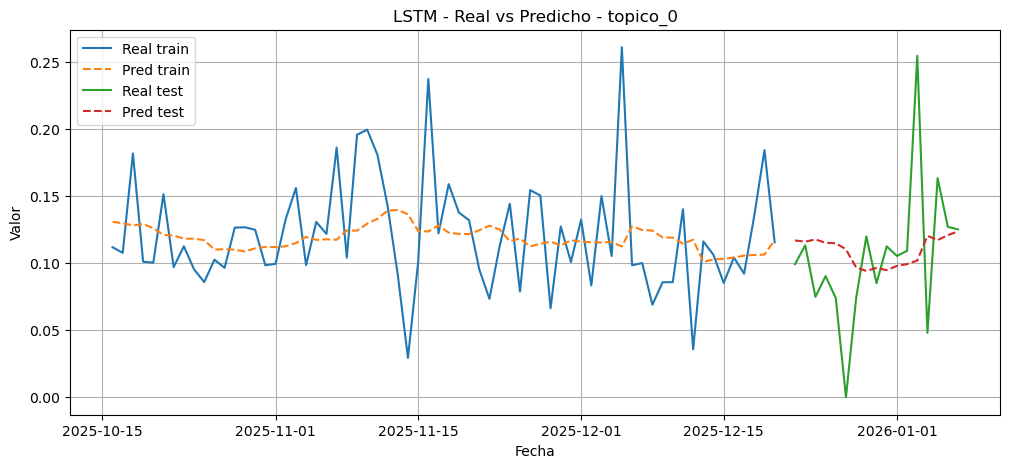

Desviación típica residuo test: 0.05349329392511206
Máximo error absoluto: 0.15252807283728426
Anomalías LSTM para topico_0:
                real  pred_lstm   residuo  abs_residuo
fecha                                                 
2026-01-03  0.254355   0.101827  0.152528     0.152528
2025-12-27  0.000000   0.110145 -0.110145     0.110145
2026-01-04  0.047901   0.120208 -0.072307     0.072307
2026-01-05  0.163206   0.117050  0.046156     0.046156
2025-12-24  0.074771   0.117556 -0.042785     0.042785
2025-12-26  0.073839   0.114719 -0.040880     0.040880
2025-12-29  0.119766   0.094059  0.025707     0.025707
2025-12-25  0.090201   0.115011 -0.024810     0.024810
2025-12-28  0.073772   0.096593 -0.022822     0.022822
2025-12-31  0.112349   0.094655  0.017695     0.017695


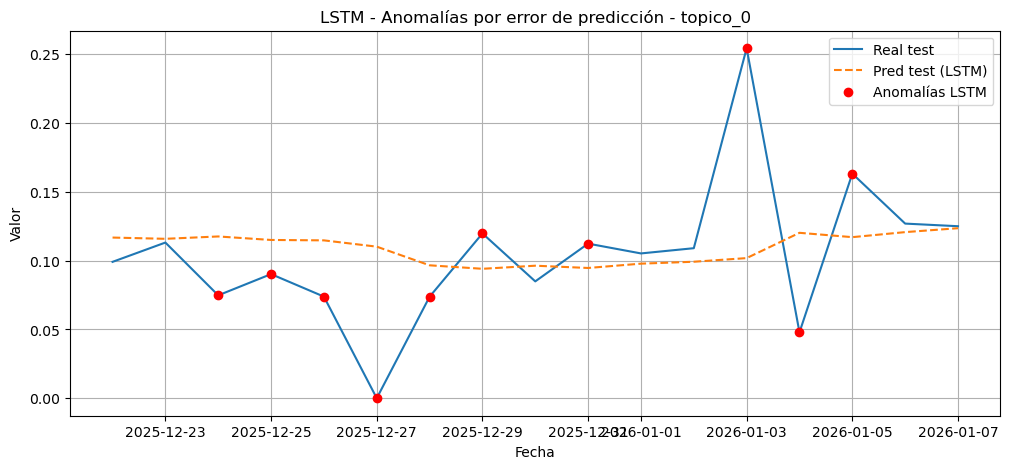

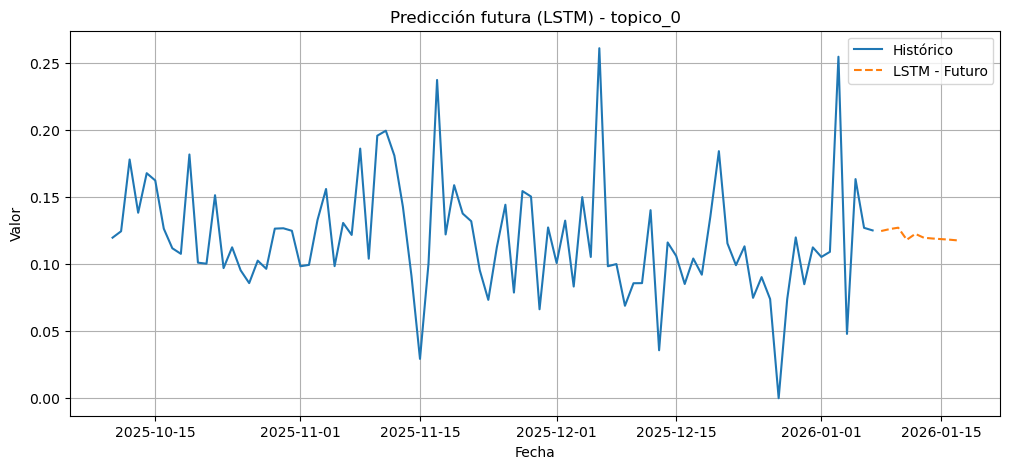


================= topico_1 =================


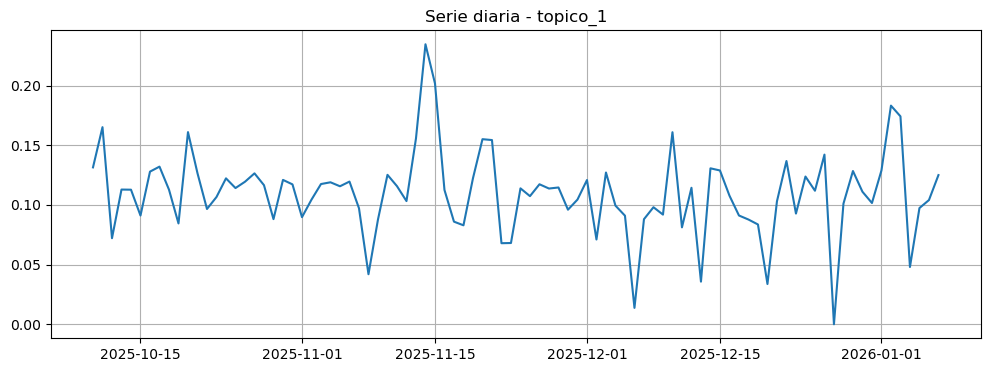

X shape: (83, 7, 1)
y shape: (83,)
Train: (66, 7, 1) (66,)
Test : (17, 7, 1) (17,)


c:\Users\alexi\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_16 (LSTM)                  │ (None, 100)            │        40,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 40,901 (159.77 KB)

 Trainable params: 40,901 (159.77 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 163ms/step - loss: 0.2361 - val_loss: 0.2050
Epoch 2/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.1564 - val_loss: 0.1492
Epoch 3/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.1173 - val_loss: 0.0979
Epoch 4/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0553 - val_loss: 0.0549
Epoch 5/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0263 - val_loss: 0.0361
Epoch 6/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0292 - val_loss: 0.0447
Epoch 7/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0322 - val_loss: 0.0371
Epoch 8/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0254 - val_loss: 0.0369
Epoch 9/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0185 - val_loss: 0.0409
Epoch 10/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0219 - val_loss: 0.0402
Epoch 11/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0207 - val_loss: 0.0380
Epoch 12/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0194 - val_loss: 0.0364


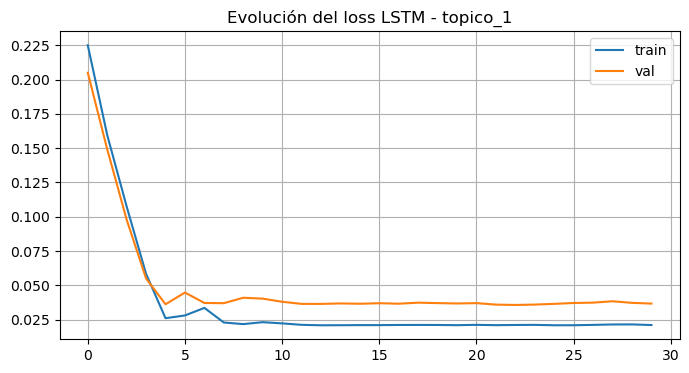

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 153ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
LSTM topico_1 - Train -> RMSE: 0.03, MAE: 0.02
LSTM topico_1 - Test  -> RMSE: 0.04, MAE: 0.03


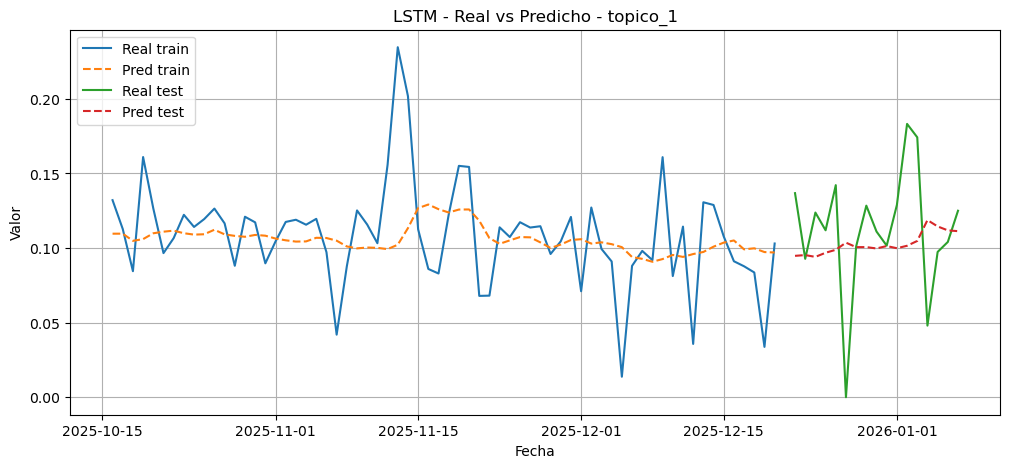

Desviación típica residuo test: 0.04388219060835062
Máximo error absoluto: 0.10361876338720322
Anomalías LSTM para topico_1:
                real  pred_lstm   residuo  abs_residuo
fecha                                                 
2025-12-27  0.000000   0.103619 -0.103619     0.103619
2026-01-02  0.183208   0.101527  0.081681     0.081681
2026-01-04  0.047996   0.118739 -0.070743     0.070743
2026-01-03  0.174218   0.104754  0.069464     0.069464
2025-12-26  0.142153   0.098815  0.043338     0.043338
2025-12-22  0.136790   0.094768  0.042022     0.042022
2025-12-24  0.123790   0.094073  0.029717     0.029717
2026-01-01  0.128888   0.099869  0.029019     0.029019
2025-12-29  0.128409   0.100622  0.027787     0.027787
2026-01-05  0.097385   0.114487 -0.017103     0.017103


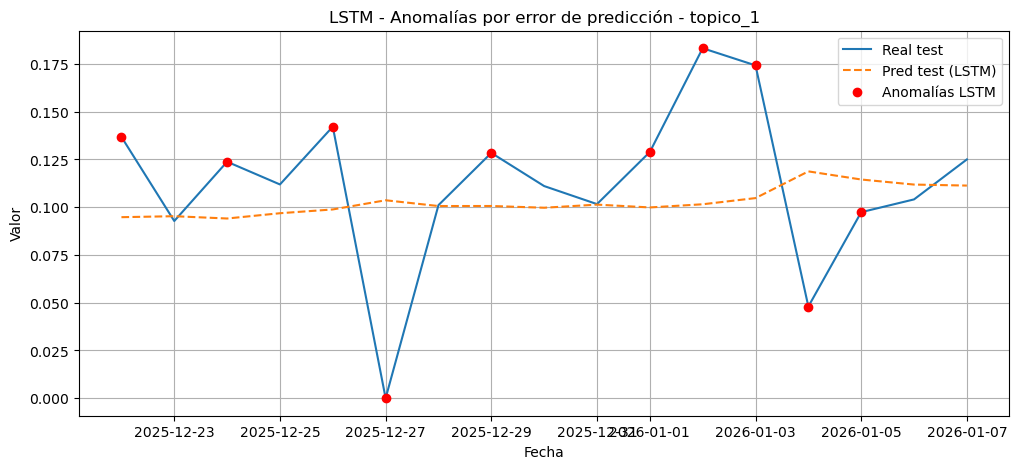

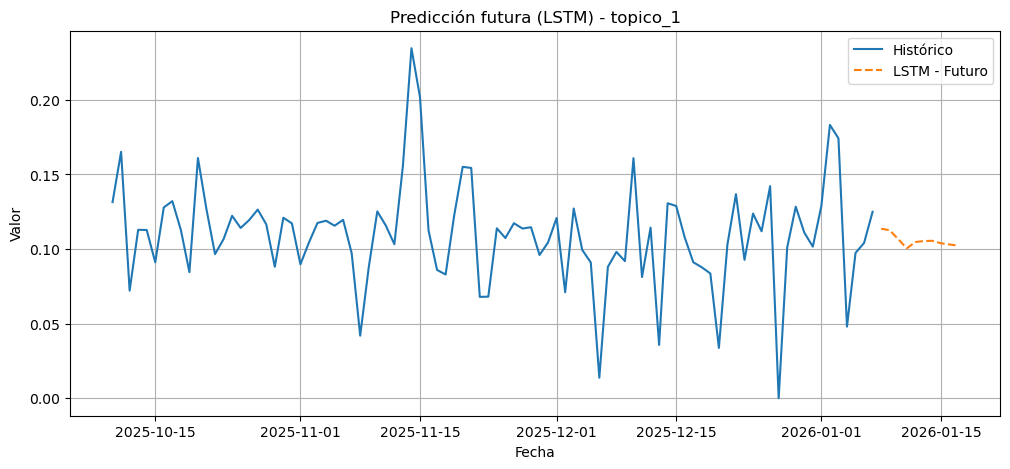


================= topico_2 =================


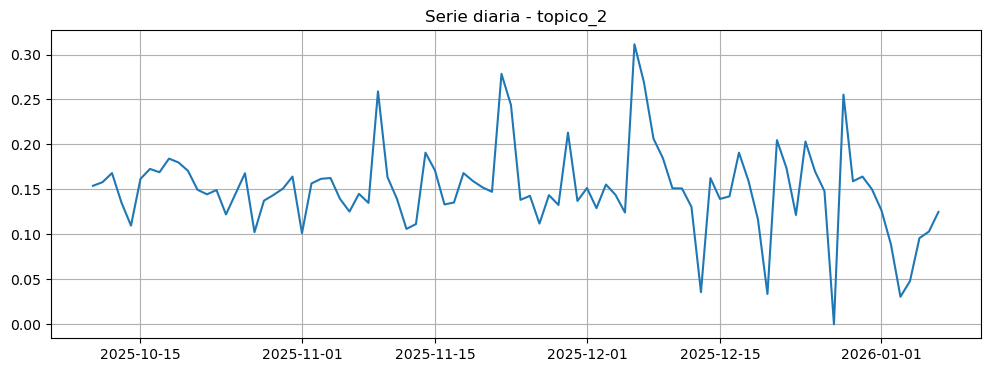

X shape: (83, 7, 1)
y shape: (83,)
Train: (66, 7, 1) (66,)
Test : (17, 7, 1) (17,)


c:\Users\alexi\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_17 (LSTM)                  │ (None, 100)            │        40,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 40,901 (159.77 KB)

 Trainable params: 40,901 (159.77 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 192ms/step - loss: 0.2874 - val_loss: 0.1856
Epoch 2/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.2271 - val_loss: 0.1462
Epoch 3/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.1877 - val_loss: 0.1127
Epoch 4/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.1361 - val_loss: 0.0810
Epoch 5/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.0873 - val_loss: 0.0522
Epoch 6/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0522 - val_loss: 0.0382
Epoch 7/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.0296 - val_loss: 0.0562
Epoch 8/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.0343 - val_loss: 0.0568
Epoch 9/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.0265 - val_loss: 0.0437
Epoch 10/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.0244 - val_loss: 0.0400
Epoch 11/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.0193 - val_loss: 0.0394
Epoch 12/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.0213 - val_loss: 0.0395


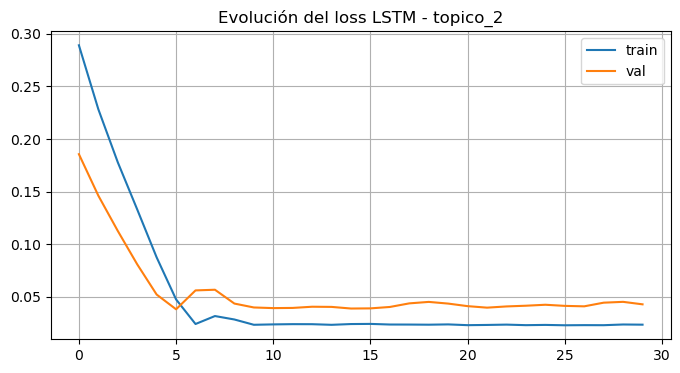

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 190ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
LSTM topico_2 - Train -> RMSE: 0.05, MAE: 0.03
LSTM topico_2 - Test  -> RMSE: 0.06, MAE: 0.05


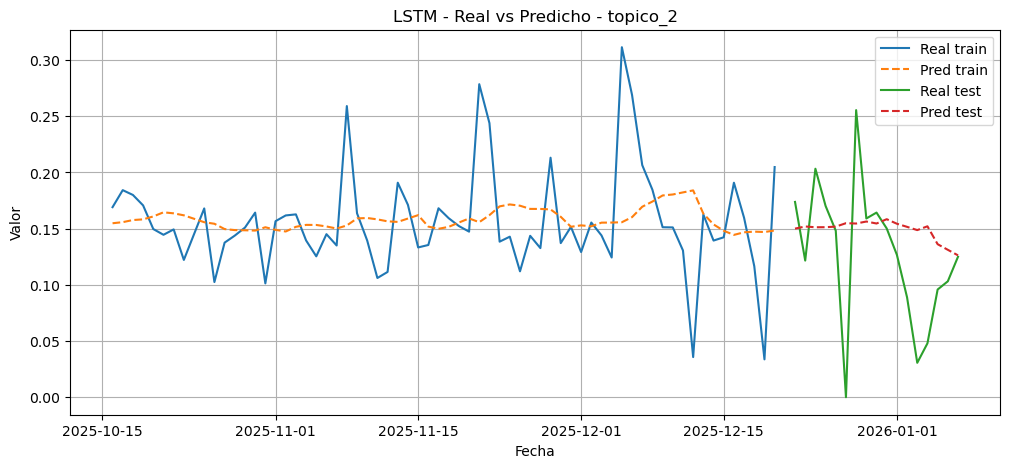

Desviación típica residuo test: 0.06072877729654401
Máximo error absoluto: 0.15484170615673065
Anomalías LSTM para topico_2:
                real  pred_lstm   residuo  abs_residuo
fecha                                                 
2025-12-27  0.000000   0.154842 -0.154842     0.154842
2026-01-03  0.030620   0.148694 -0.118074     0.118074
2026-01-04  0.047956   0.152080 -0.104124     0.104124
2025-12-28  0.255451   0.154542  0.100910     0.100910
2026-01-02  0.088813   0.151583 -0.062770     0.062770
2025-12-24  0.203311   0.151222  0.052089     0.052089
2026-01-05  0.095829   0.136158 -0.040329     0.040329
2025-12-23  0.121590   0.151918 -0.030328     0.030328
2026-01-06  0.103139   0.131161 -0.028022     0.028022
2026-01-01  0.126692   0.154357 -0.027665     0.027665


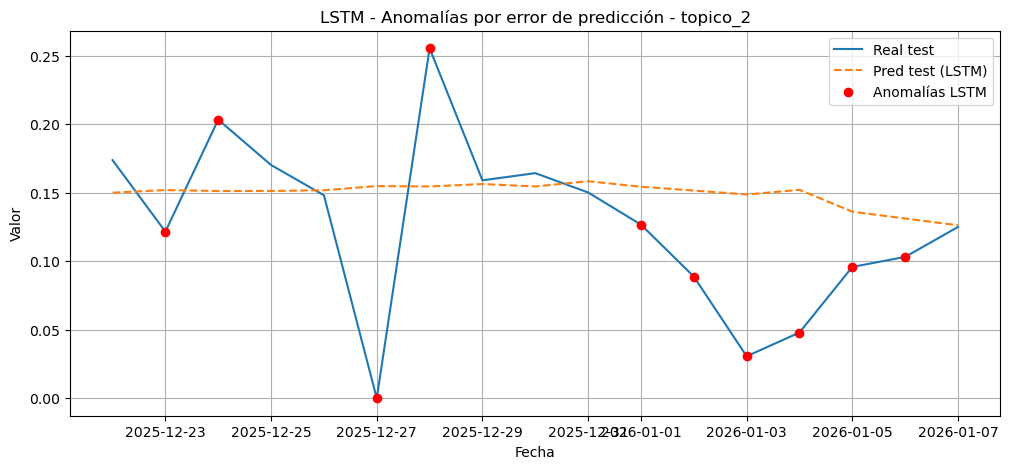

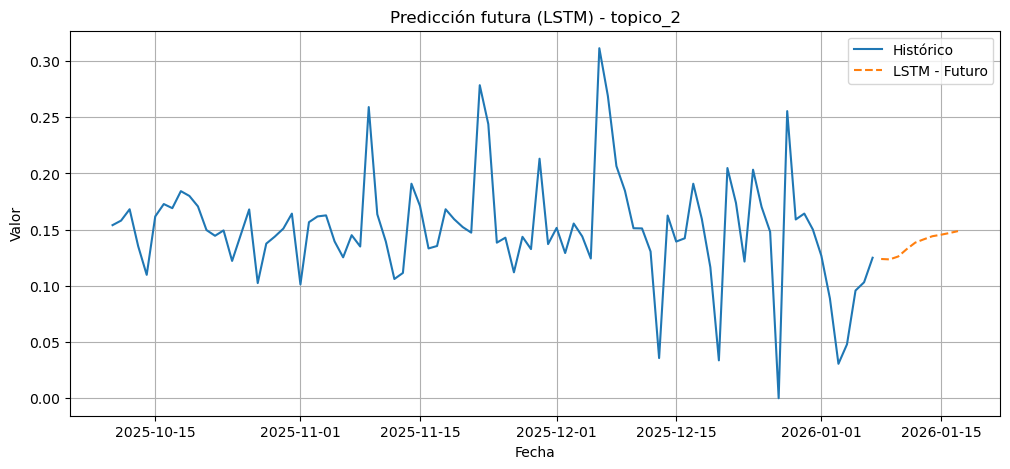


================= topico_3 =================


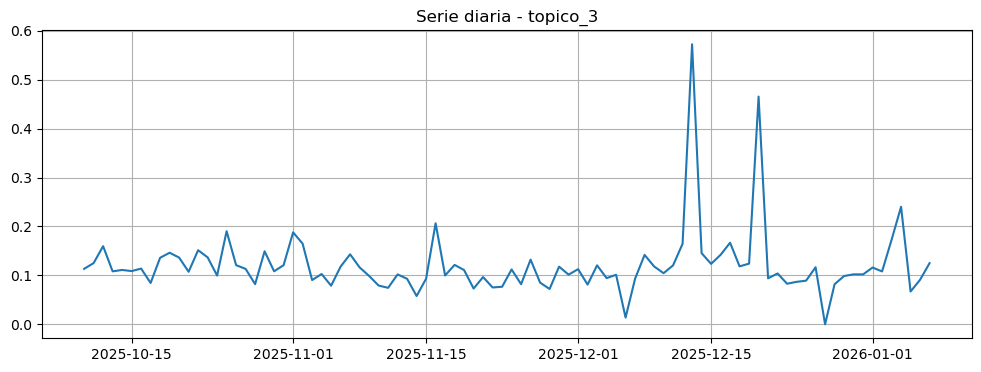

X shape: (83, 7, 1)
y shape: (83,)
Train: (66, 7, 1) (66,)
Test : (17, 7, 1) (17,)


c:\Users\alexi\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_18 (LSTM)                  │ (None, 100)            │        40,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 40,901 (159.77 KB)

 Trainable params: 40,901 (159.77 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 206ms/step - loss: 0.0441 - val_loss: 0.0184
Epoch 2/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0454 - val_loss: 0.0094
Epoch 3/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.0139 - val_loss: 0.0098
Epoch 4/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0238 - val_loss: 0.0154
Epoch 5/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.0183 - val_loss: 0.0128
Epoch 6/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.0119 - val_loss: 0.0095
Epoch 7/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.0162 - val_loss: 0.0087
Epoch 8/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0254 - val_loss: 0.0089
Epoch 9/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0151 - val_loss: 0.0089
Epoch 10/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0124 - val_loss: 0.0094
Epoch 11/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0165 - val_loss: 0.0101
Epoch 12/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0156 - val_loss: 0.0110


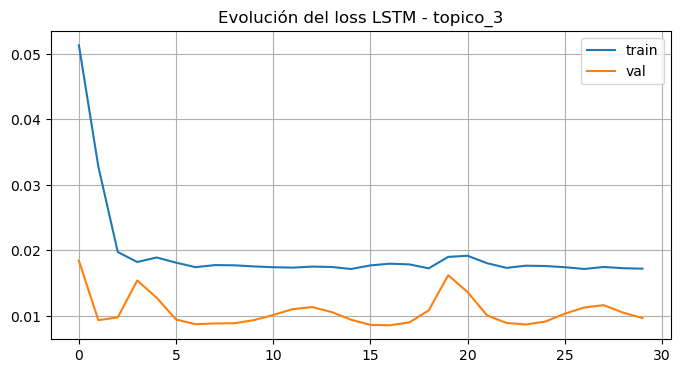

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 196ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
LSTM topico_3 - Train -> RMSE: 0.08, MAE: 0.04
LSTM topico_3 - Test  -> RMSE: 0.06, MAE: 0.04


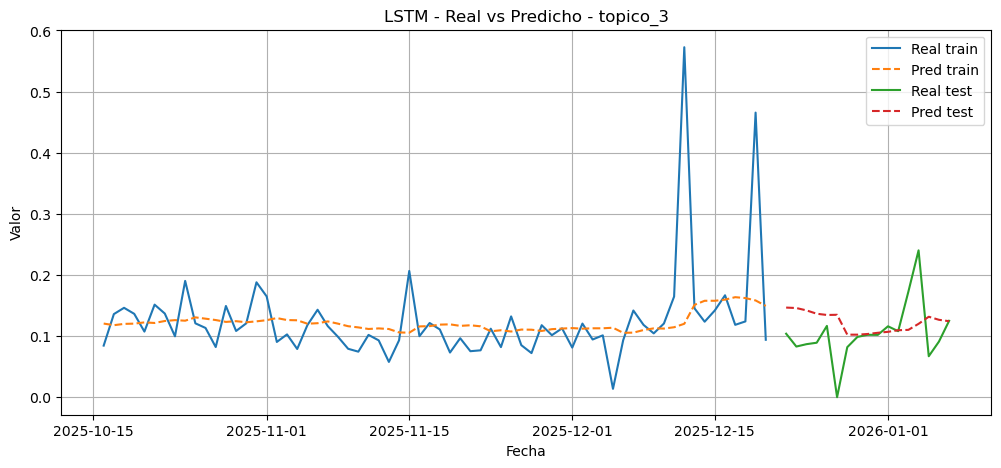

Desviación típica residuo test: 0.0534973407730609
Máximo error absoluto: 0.13484610617160797
Anomalías LSTM para topico_3:
                real  pred_lstm   residuo  abs_residuo
fecha                                                 
2025-12-27  0.000000   0.134846 -0.134846     0.134846
2026-01-04  0.240220   0.120055  0.120164     0.120164
2026-01-05  0.067027   0.131645 -0.064618     0.064618
2025-12-23  0.082898   0.145899 -0.063001     0.063001
2026-01-03  0.172728   0.110189  0.062539     0.062539
2025-12-24  0.086786   0.142027 -0.055241     0.055241
2025-12-25  0.089154   0.136570 -0.047416     0.047416
2025-12-22  0.103893   0.146637 -0.042743     0.042743
2026-01-06  0.091007   0.126655 -0.035648     0.035648
2025-12-28  0.081870   0.102366 -0.020496     0.020496


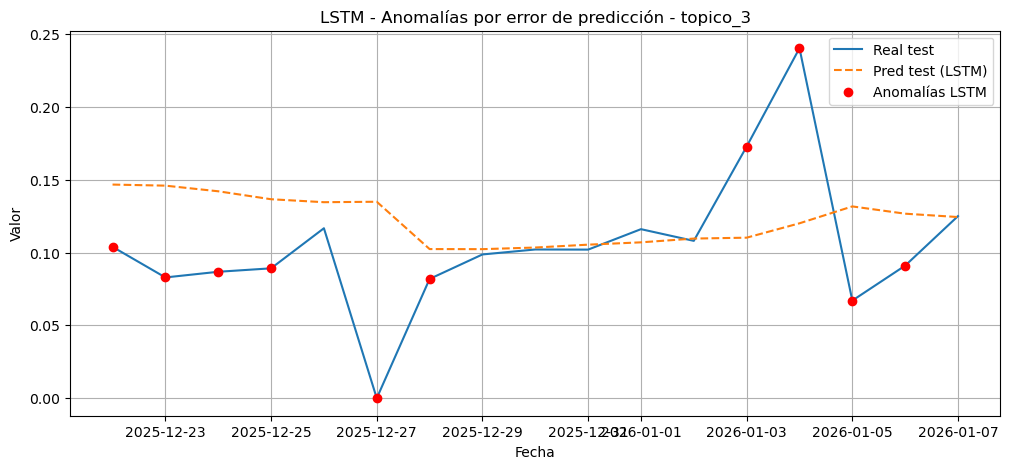

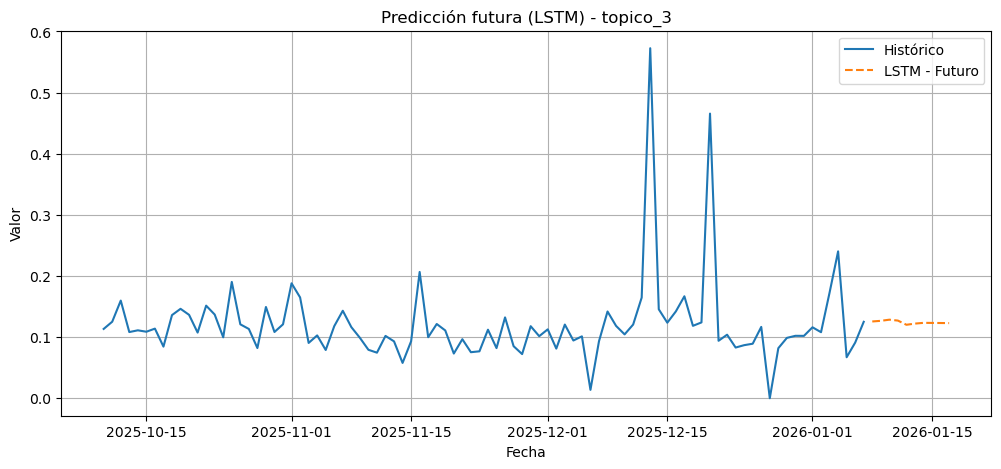


================= topico_4 =================


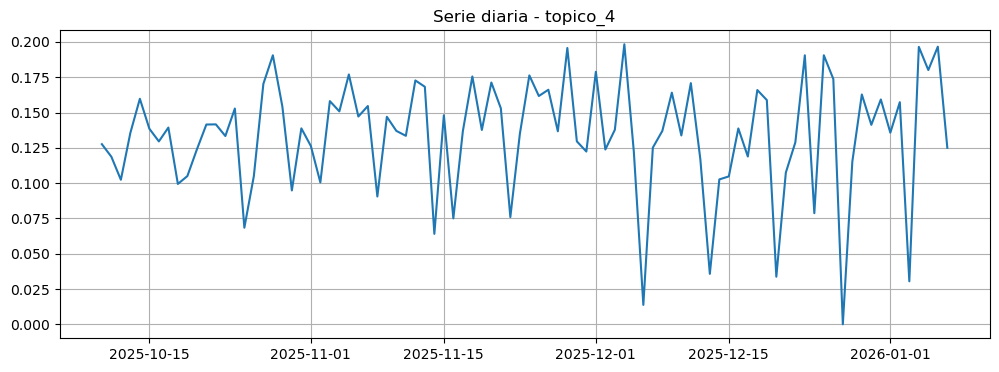

X shape: (83, 7, 1)
y shape: (83,)
Train: (66, 7, 1) (66,)
Test : (17, 7, 1) (17,)


c:\Users\alexi\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_19 (LSTM)                  │ (None, 100)            │        40,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 40,901 (159.77 KB)

 Trainable params: 40,901 (159.77 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 206ms/step - loss: 0.4399 - val_loss: 0.4250
Epoch 2/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.3487 - val_loss: 0.3150
Epoch 3/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.2140 - val_loss: 0.2069
Epoch 4/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.1155 - val_loss: 0.1069
Epoch 5/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0479 - val_loss: 0.0768
Epoch 6/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0623 - val_loss: 0.0802
Epoch 7/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.0474 - val_loss: 0.0748
Epoch 8/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0346 - val_loss: 0.0892
Epoch 9/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.0425 - val_loss: 0.0959
Epoch 10/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.0494 - val_loss: 0.0900
Epoch 11/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0397 - val_loss: 0.0776
Epoch 12/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.0426 - val_loss: 0.0764


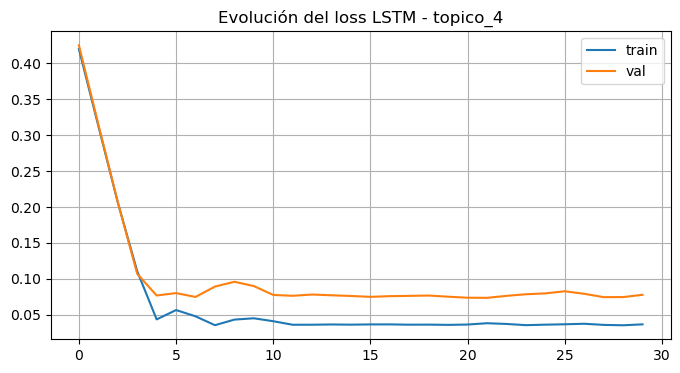

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 206ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
LSTM topico_4 - Train -> RMSE: 0.04, MAE: 0.03
LSTM topico_4 - Test  -> RMSE: 0.06, MAE: 0.05


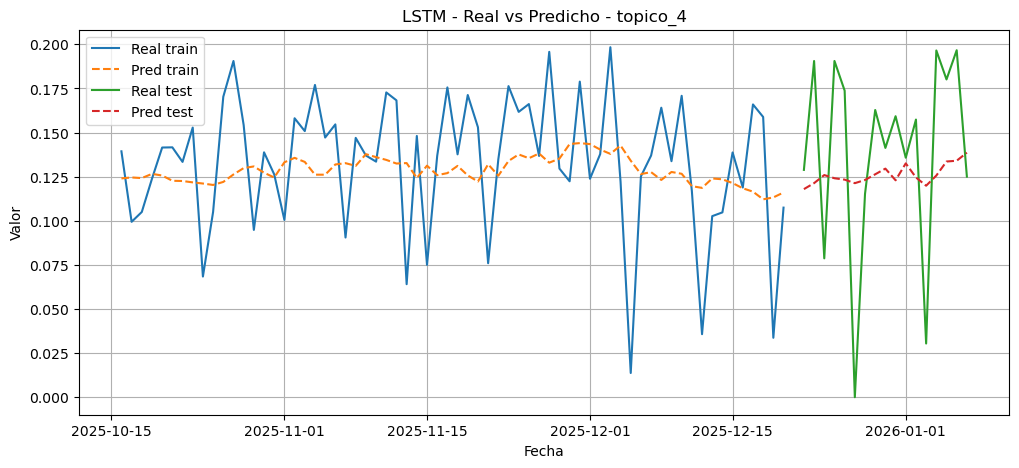

Desviación típica residuo test: 0.053817159686583314
Máximo error absoluto: 0.12130008637905121
Anomalías LSTM para topico_4:
                real  pred_lstm   residuo  abs_residuo
fecha                                                 
2025-12-27  0.000000   0.121300 -0.121300     0.121300
2026-01-03  0.030433   0.119863 -0.089430     0.089430
2026-01-04  0.196511   0.125614  0.070897     0.070897
2025-12-23  0.190532   0.121320  0.069212     0.069212
2025-12-25  0.190557   0.124086  0.066471     0.066471
2026-01-06  0.196643   0.134016  0.062627     0.062627
2025-12-26  0.173734   0.123305  0.050429     0.050429
2025-12-24  0.078695   0.125888 -0.047193     0.047193
2026-01-05  0.180086   0.133569  0.046517     0.046517
2025-12-29  0.162769   0.126331  0.036438     0.036438


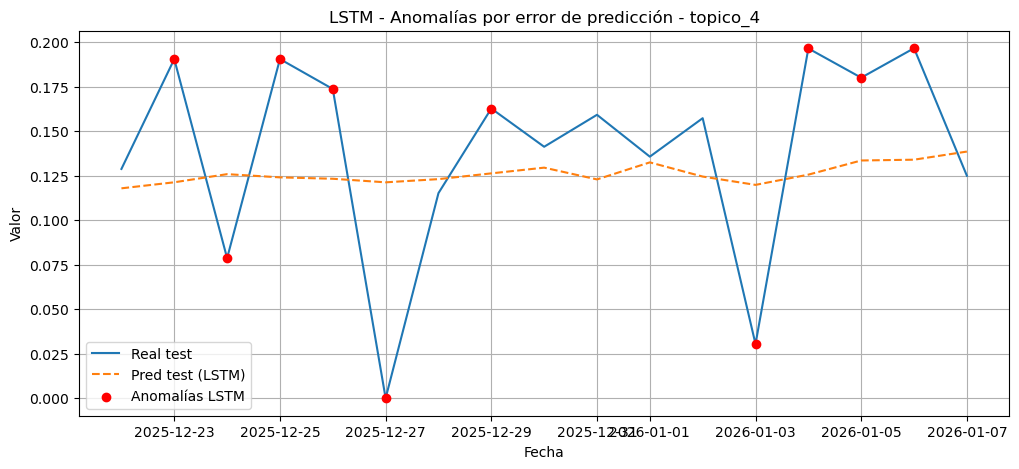

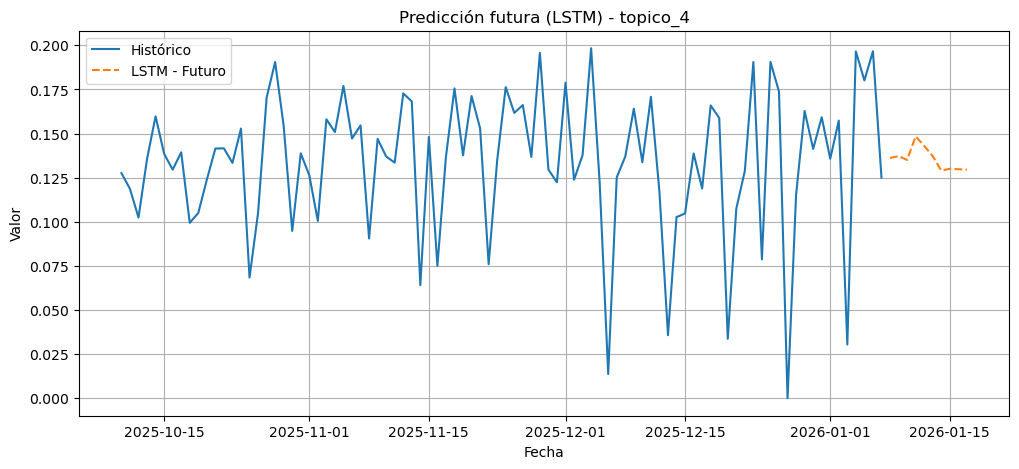


================= topico_5 =================


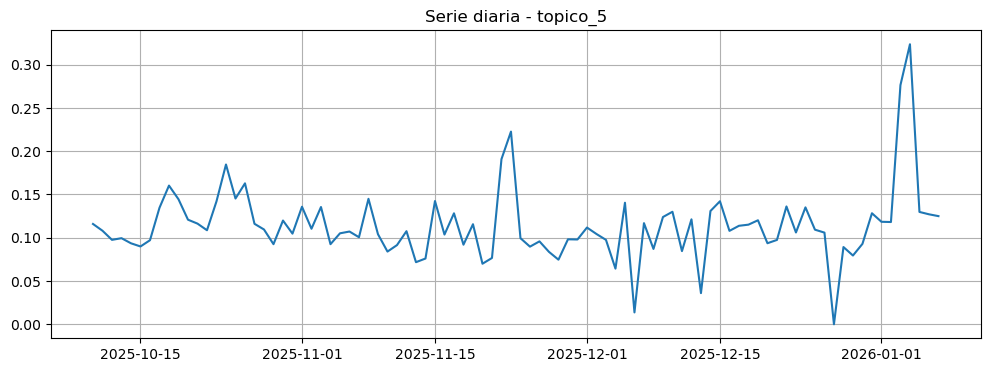

X shape: (83, 7, 1)
y shape: (83,)
Train: (66, 7, 1) (66,)
Test : (17, 7, 1) (17,)


c:\Users\alexi\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_20 (LSTM)                  │ (None, 100)            │        40,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 40,901 (159.77 KB)

 Trainable params: 40,901 (159.77 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 179ms/step - loss: 0.1071 - val_loss: 0.1388
Epoch 2/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.0698 - val_loss: 0.1030
Epoch 3/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.0357 - val_loss: 0.0745
Epoch 4/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.0199 - val_loss: 0.0533
Epoch 5/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.0108 - val_loss: 0.0490
Epoch 6/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.0144 - val_loss: 0.0489
Epoch 7/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0128 - val_loss: 0.0488
Epoch 8/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.0110 - val_loss: 0.0515
Epoch 9/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0102 - val_loss: 0.0527
Epoch 10/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0115 - val_loss: 0.0515
Epoch 11/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0090 - val_loss: 0.0497
Epoch 12/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.0085 - val_loss: 0.0487


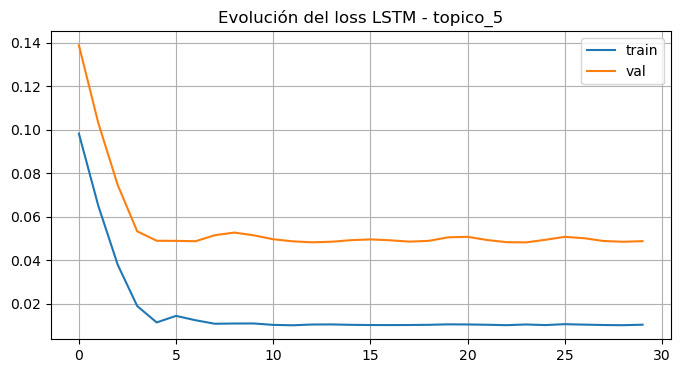

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 222ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
LSTM topico_5 - Train -> RMSE: 0.03, MAE: 0.02
LSTM topico_5 - Test  -> RMSE: 0.07, MAE: 0.04


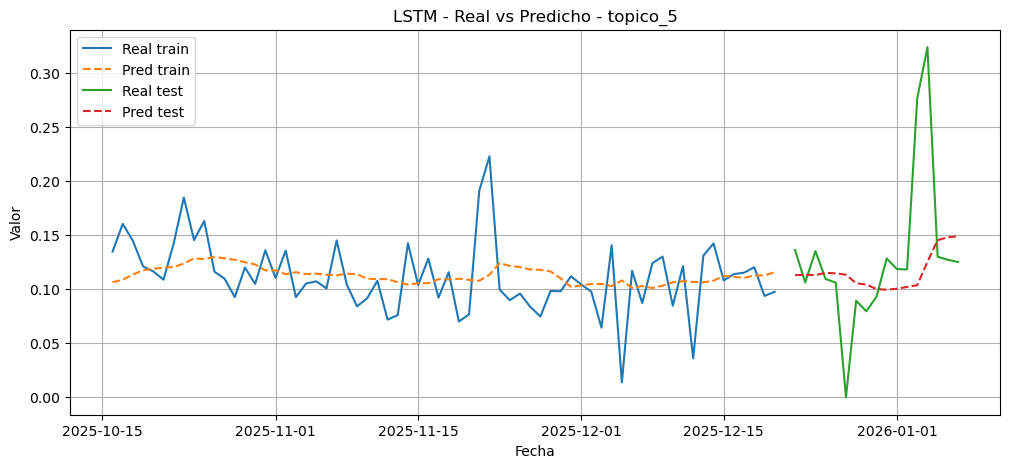

Desviación típica residuo test: 0.07010037992479733
Máximo error absoluto: 0.19841772894295834
Anomalías LSTM para topico_5:
                real  pred_lstm   residuo  abs_residuo
fecha                                                 
2026-01-04  0.323616   0.125198  0.198418     0.198418
2026-01-03  0.276452   0.103612  0.172840     0.172840
2025-12-27  0.000000   0.113299 -0.113299     0.113299
2025-12-31  0.128316   0.099384  0.028932     0.028932
2025-12-29  0.079460   0.104157 -0.024697     0.024697
2026-01-07  0.125000   0.148862 -0.023862     0.023862
2025-12-22  0.136181   0.112892  0.023289     0.023289
2025-12-24  0.135118   0.112942  0.022176     0.022176
2026-01-06  0.127115   0.147904 -0.020789     0.020789
2026-01-01  0.118453   0.100305  0.018147     0.018147


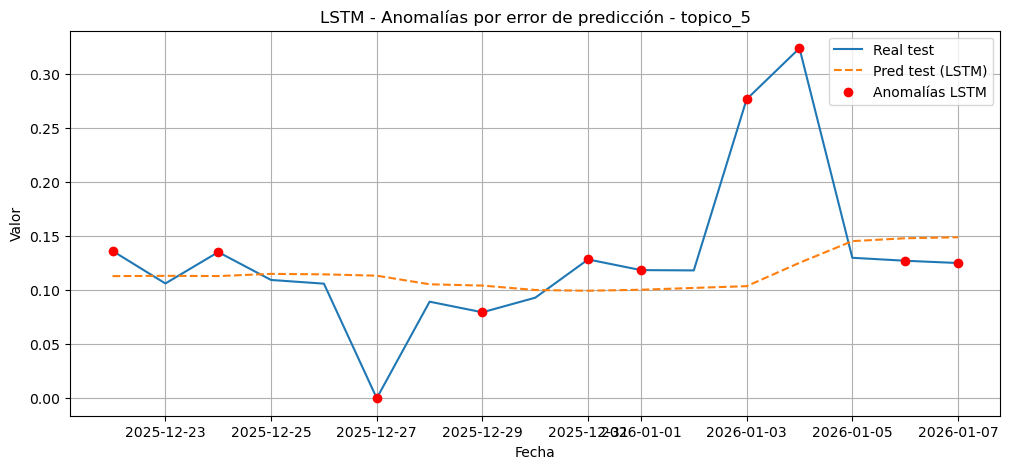

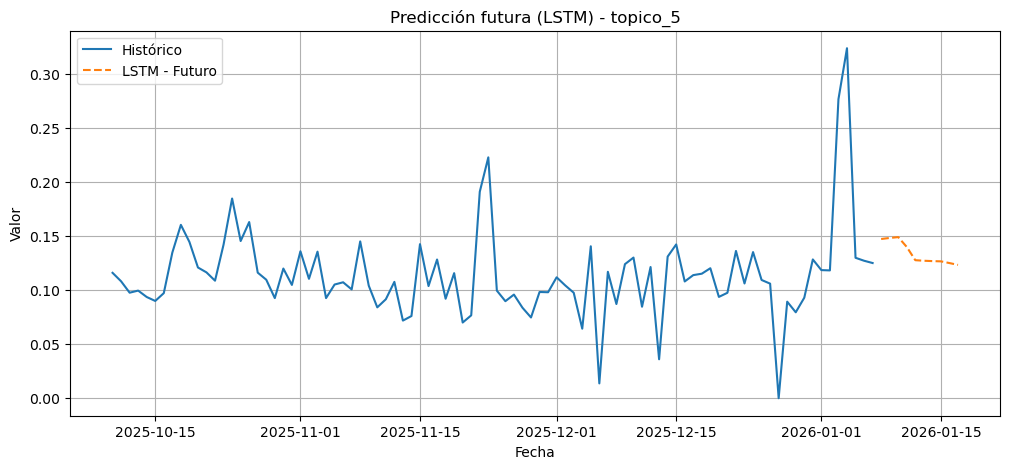


================= topico_6 =================


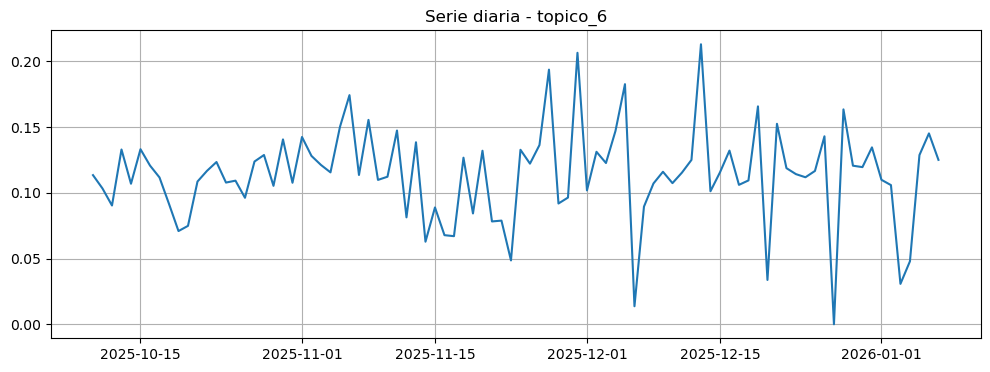

X shape: (83, 7, 1)
y shape: (83,)
Train: (66, 7, 1) (66,)
Test : (17, 7, 1) (17,)


c:\Users\alexi\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_21 (LSTM)                  │ (None, 100)            │        40,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 40,901 (159.77 KB)

 Trainable params: 40,901 (159.77 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 173ms/step - loss: 0.2785 - val_loss: 0.2100
Epoch 2/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.2211 - val_loss: 0.1479
Epoch 3/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.1381 - val_loss: 0.0901
Epoch 4/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.0743 - val_loss: 0.0462
Epoch 5/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0382 - val_loss: 0.0492
Epoch 6/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0434 - val_loss: 0.0603
Epoch 7/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.0541 - val_loss: 0.0426
Epoch 8/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0265 - val_loss: 0.0395
Epoch 9/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0323 - val_loss: 0.0400
Epoch 10/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0342 - val_loss: 0.0396
Epoch 11/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0314 - val_loss: 0.0401
Epoch 12/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0319 - val_loss: 0.0400


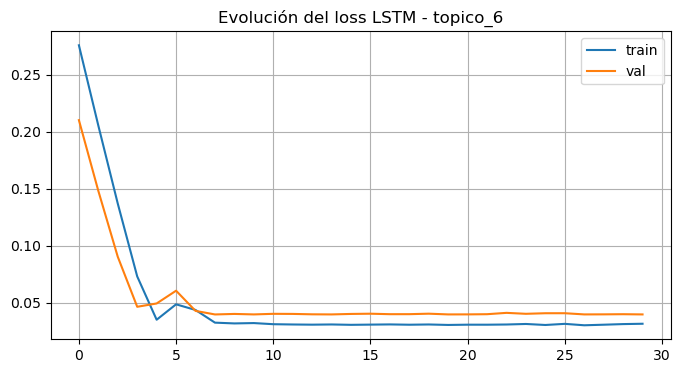

3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 749ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
LSTM topico_6 - Train -> RMSE: 0.04, MAE: 0.03
LSTM topico_6 - Test  -> RMSE: 0.04, MAE: 0.03


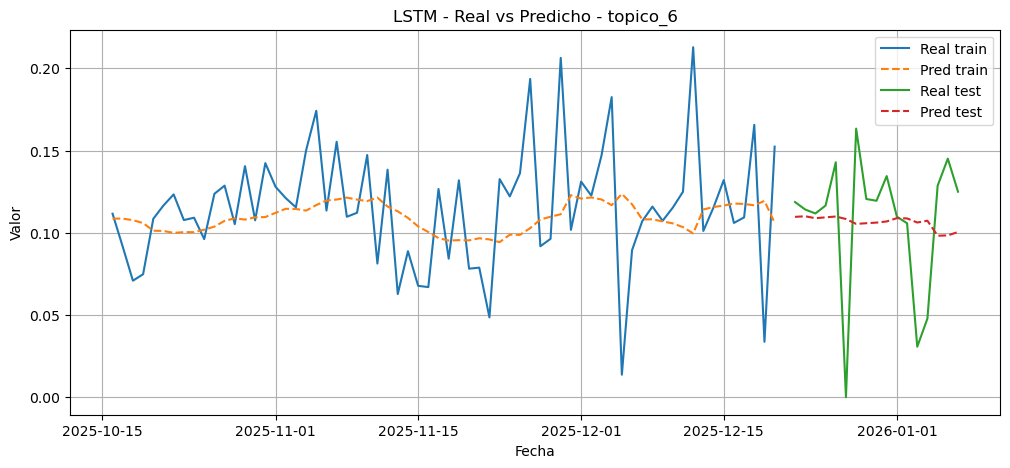

Desviación típica residuo test: 0.04230419518778099
Máximo error absoluto: 0.10839882493019104
Anomalías LSTM para topico_6:
                real  pred_lstm   residuo  abs_residuo
fecha                                                 
2025-12-27  0.000000   0.108399 -0.108399     0.108399
2026-01-03  0.030719   0.106261 -0.075542     0.075542
2026-01-04  0.047901   0.107333 -0.059432     0.059432
2025-12-28  0.163367   0.105414  0.057953     0.057953
2026-01-06  0.145110   0.098419  0.046691     0.046691
2025-12-26  0.142899   0.109908  0.032991     0.032991
2026-01-05  0.128644   0.098223  0.030421     0.030421
2025-12-31  0.134491   0.106911  0.027580     0.027580
2026-01-07  0.125000   0.100482  0.024518     0.024518
2025-12-29  0.120562   0.105834  0.014728     0.014728


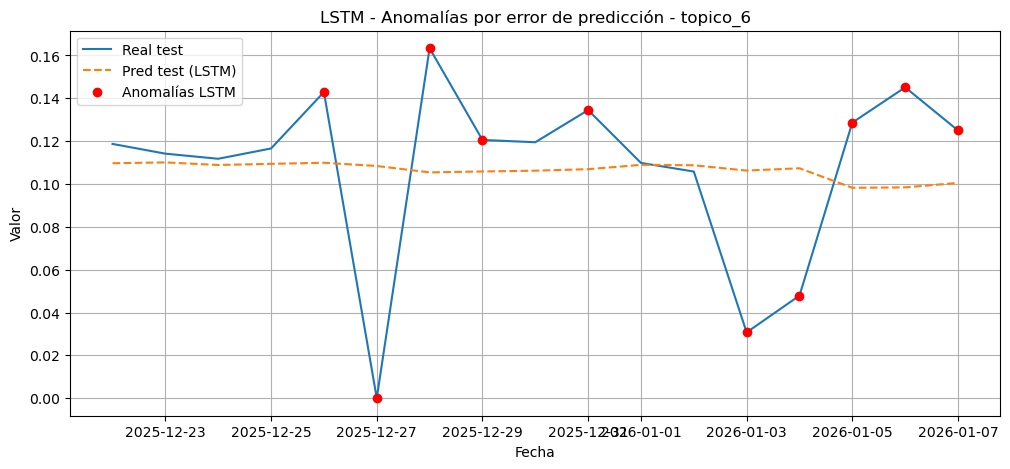

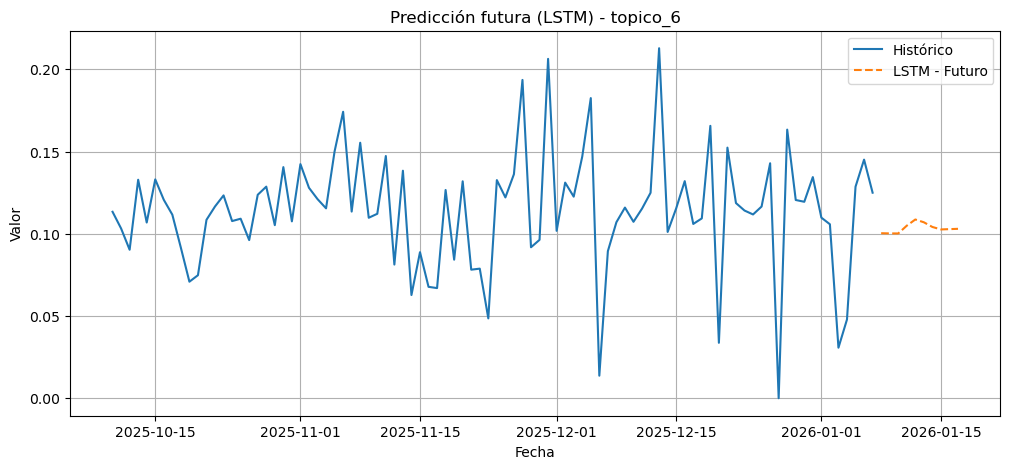


================= topico_7 =================


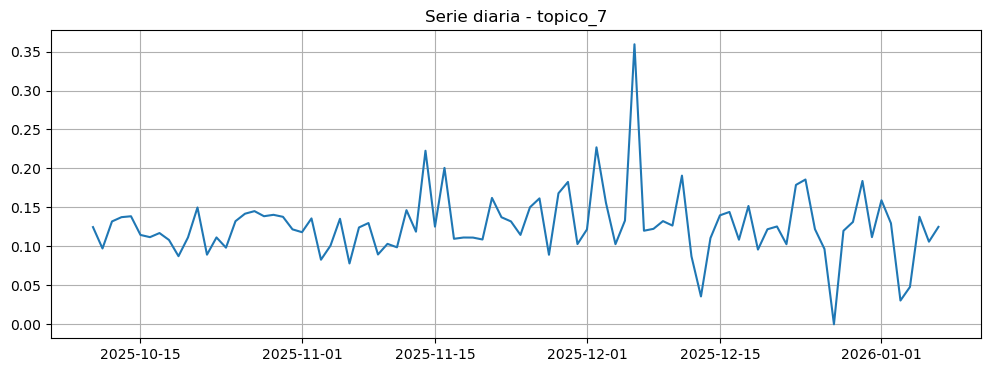

X shape: (83, 7, 1)
y shape: (83,)
Train: (66, 7, 1) (66,)
Test : (17, 7, 1) (17,)


c:\Users\alexi\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_22"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_22 (LSTM)                  │ (None, 100)            │        40,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 40,901 (159.77 KB)

 Trainable params: 40,901 (159.77 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 213ms/step - loss: 0.1220 - val_loss: 0.0763
Epoch 2/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.0829 - val_loss: 0.0464
Epoch 3/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.0436 - val_loss: 0.0263
Epoch 4/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.0217 - val_loss: 0.0217
Epoch 5/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0217 - val_loss: 0.0304
Epoch 6/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.0231 - val_loss: 0.0275
Epoch 7/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0184 - val_loss: 0.0224
Epoch 8/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0126 - val_loss: 0.0210
Epoch 9/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.0119 - val_loss: 0.0210
Epoch 10/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0197 - val_loss: 0.0209
Epoch 11/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.0178 - val_loss: 0.0211
Epoch 12/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0137 - val_loss: 0.0214


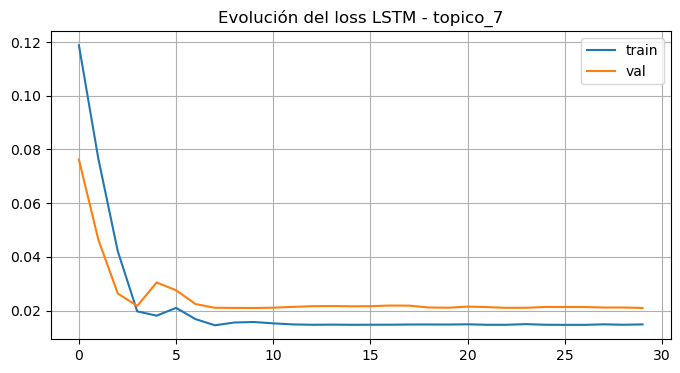

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 199ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
LSTM topico_7 - Train -> RMSE: 0.04, MAE: 0.03
LSTM topico_7 - Test  -> RMSE: 0.05, MAE: 0.04


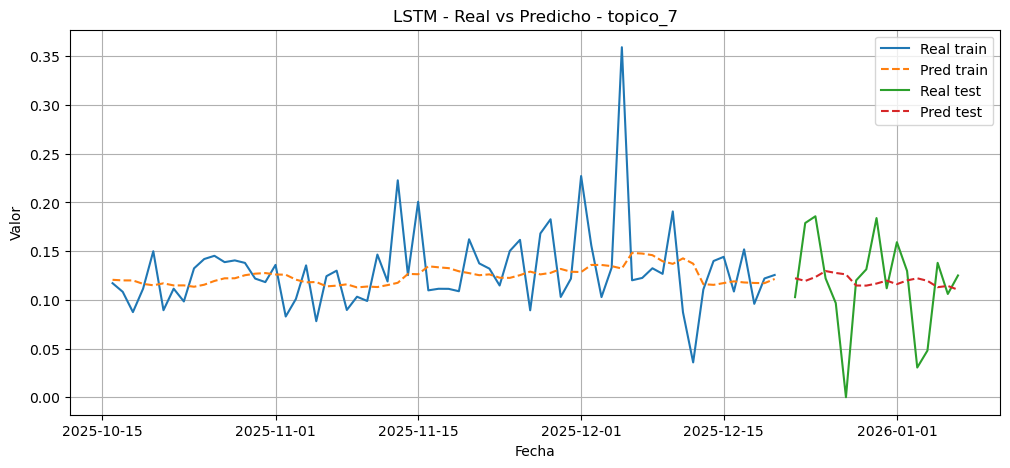

Desviación típica residuo test: 0.05190012723135191
Máximo error absoluto: 0.1261155605316162
Anomalías LSTM para topico_7:
                real  pred_lstm   residuo  abs_residuo
fecha                                                 
2025-12-27  0.000000   0.126116 -0.126116     0.126116
2026-01-03  0.030475   0.122114 -0.091639     0.091639
2026-01-04  0.047900   0.119515 -0.071615     0.071615
2025-12-30  0.183948   0.116691  0.067257     0.067257
2025-12-24  0.185764   0.123373  0.062391     0.062391
2025-12-23  0.178847   0.119386  0.059461     0.059461
2026-01-01  0.159157   0.116071  0.043086     0.043086
2025-12-26  0.096645   0.127579 -0.030934     0.030934
2026-01-05  0.137969   0.112972  0.024997     0.024997
2025-12-22  0.102752   0.122142 -0.019390     0.019390


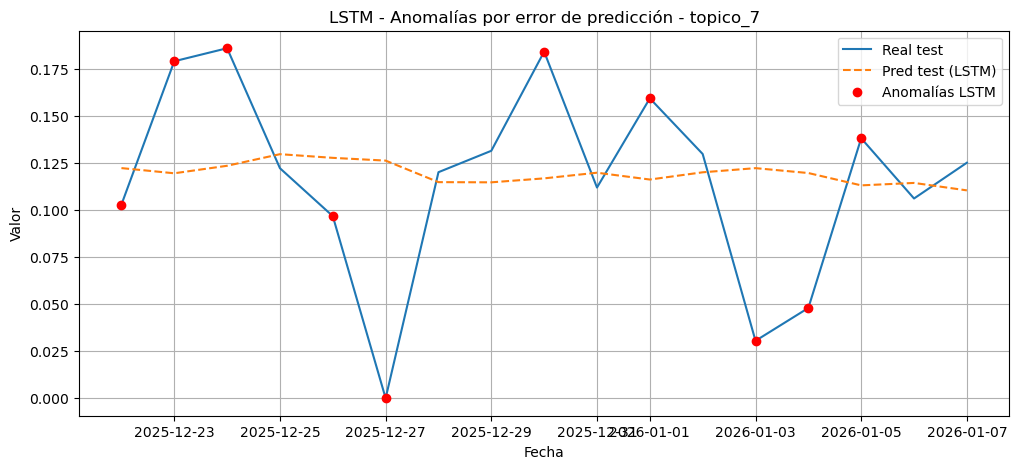

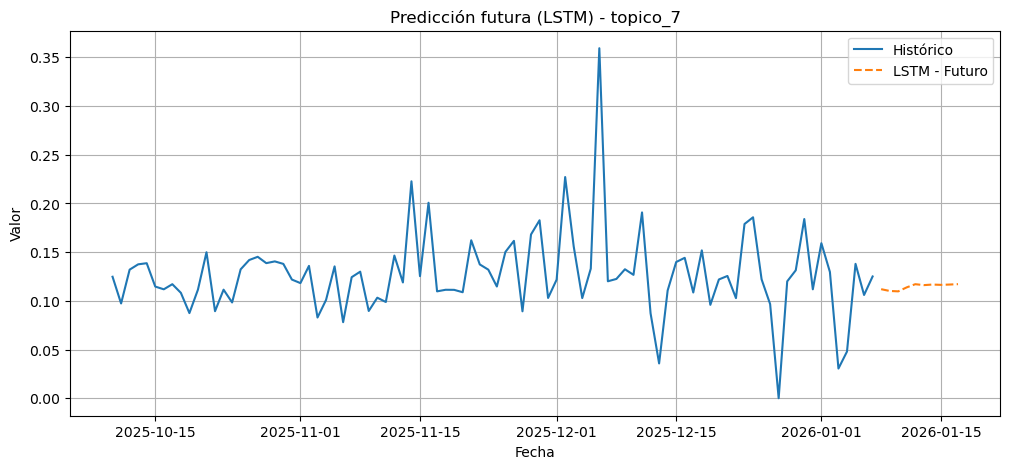

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Aquí almacenamos resultados y salidas de interés
resultados_lstm = []        # métricas por tópico (RMSE/MAE)
anomalias_por_topico = {}   # top-N anomalías por tópico
futuro_por_topico = {}      # predicción futura por tópico

for TOPICO in TOPICOS:
    print(f"\n================= {TOPICO} =================")
    
    # --- Serie diaria de ese tópico ---
    # Agrupamos por día y calculamos la media diaria del valor del tópico
    serie = agrupar(df, TOPICO, freq="D")   # índice: fecha, valores: media diaria del tópico

    # Visualización rápida de la serie (se puede comentar para evitar 8 gráficos)
    plt.figure(figsize=(12,4))
    plt.plot(serie.index, serie.values)
    plt.title(f"Serie diaria - {TOPICO}")
    plt.grid(True)
    plt.show()

    # --- Preparación de datos ---
    n_input = 7     # nº de días de historial que usamos como entrada
    n_features = 1  # una única variable (el propio tópico)

    # Ordenar por fecha e imputar posibles huecos con interpolación temporal
    serie = serie.sort_index()
    serie = serie.interpolate(method="time").ffill().bfill()

    # Escalado Min-Max a [0, 1], necesario para estabilizar el entrenamiento de la LSTM
    values = serie.values.reshape(-1, 1)
    scaler = MinMaxScaler(feature_range=(0, 1))
    values_scaled = scaler.fit_transform(values)

    # Función auxiliar para crear ventanas (secuencias) de longitud n_input
    def crear_secuencias(data_scaled, n_input):
        X, y = [], []
        for i in range(len(data_scaled) - n_input):
            # Ventana de entrada: n_input días anteriores
            X.append(data_scaled[i:i+n_input, 0])
            # Etiqueta: valor del día siguiente
            y.append(data_scaled[i+n_input, 0])
        X = np.array(X)
        y = np.array(y)
        # La LSTM espera una entrada 3D: (muestras, timesteps, features)
        X = X.reshape((X.shape[0], X.shape[1], 1))
        return X, y

    X, y = crear_secuencias(values_scaled, n_input)

    print("X shape:", X.shape)
    print("y shape:", y.shape)

    # Split train/test sobre las ventanas (80/20)
    train_size = int(len(X) * 0.8)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]

    print("Train:", X_train.shape, y_train.shape)
    print("Test :", X_test.shape, y_test.shape)

    # --- Modelo LSTM ---
    # Arquitectura sencilla: una capa LSTM + una capa densa de salida
    model = Sequential()
    model.add(LSTM(100, activation='relu', input_shape=(n_input, n_features)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')

    model.summary()

    # Entrenamiento del modelo con validación en el conjunto de test
    history = model.fit(
        X_train, y_train,
        epochs=30,
        batch_size=16,
        validation_data=(X_test, y_test),
        verbose=1
    )

    # Evolución del loss (se puede comentar si no se quieren 8 gráficas)
    plt.figure(figsize=(8,4))
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='val')
    plt.title(f"Evolución del loss LSTM - {TOPICO}")
    plt.legend()
    plt.grid(True)
    plt.show()

    # --- Predicción sobre train y test ---
    y_train_pred_scaled = model.predict(X_train)
    y_test_pred_scaled  = model.predict(X_test)

    # Desescalado de reales y predicciones para volver a la escala original
    y_train_real = scaler.inverse_transform(y_train.reshape(-1,1)).ravel()
    y_test_real  = scaler.inverse_transform(y_test.reshape(-1,1)).ravel()

    y_train_pred = scaler.inverse_transform(y_train_pred_scaled).ravel()
    y_test_pred  = scaler.inverse_transform(y_test_pred_scaled).ravel()

    # Métricas de error: comparamos periodo de entrenamiento y test
    rmse_train = np.sqrt(mean_squared_error(y_train_real, y_train_pred))
    mae_train  = mean_absolute_error(y_train_real, y_train_pred)

    rmse_test = np.sqrt(mean_squared_error(y_test_real, y_test_pred))
    mae_test  = mean_absolute_error(y_test_real, y_test_pred)

    print(f"LSTM {TOPICO} - Train -> RMSE: {rmse_train:.2f}, MAE: {mae_train:.2f}")
    print(f"LSTM {TOPICO} - Test  -> RMSE: {rmse_test:.2f}, MAE: {mae_test:.2f}")

    # Guardar métricas en una lista para construir luego una tabla
    resultados_lstm.append({
        "topico": TOPICO,
        "rmse_train": rmse_train,
        "mae_train": mae_train,
        "rmse_test": rmse_test,
        "mae_test": mae_test
    })

    # --- Alinear fechas train/test con y_train_real y y_test_real ---
    # Partimos la serie original en el mismo punto (80/20) que las ventanas
    n_total = len(serie)
    n_train_series = int(n_total * 0.8)
    serie_train = serie.iloc[:n_train_series]
    serie_test  = serie.iloc[n_train_series:]

    # Asociamos a cada valor de y_real la última parte de las fechas correspondientes
    fechas_train = serie_train.index[-len(y_train_real):]
    fechas_test  = serie_test.index[-len(y_test_real):]

    # Gráfico Real vs Predicho (train y test)
    plt.figure(figsize=(12,5))
    plt.plot(fechas_train, y_train_real, label="Real train")
    plt.plot(fechas_train, y_train_pred, label="Pred train", linestyle='--')

    plt.plot(fechas_test, y_test_real, label="Real test")
    plt.plot(fechas_test, y_test_pred, label="Pred test", linestyle='--')

    plt.title(f"LSTM - Real vs Predicho - {TOPICO}")
    plt.xlabel("Fecha")
    plt.ylabel("Valor")
    plt.legend()
    plt.grid(True)
    plt.show()

    # --- Residuo en test y anomalías (TOP N) ---
    # El residuo mide cuánto se equivoca el modelo cada día
    residuo_test = y_test_real - y_test_pred
    abs_residuo_test = np.abs(residuo_test)

    print("Desviación típica residuo test:", residuo_test.std())
    print("Máximo error absoluto:", abs_residuo_test.max())

    N = 10  # número de anomalías que queremos guardar
    df_res_test = pd.DataFrame({
        "fecha": fechas_test,
        "real": y_test_real,
        "pred_lstm": y_test_pred,
        "residuo": residuo_test,
        "abs_residuo": abs_residuo_test
    }).set_index("fecha")

    # Seleccionamos los N días con mayor error absoluto como anomalías
    anomalias_topN = df_res_test.sort_values("abs_residuo", ascending=False).head(N)
    anomalias_por_topico[TOPICO] = anomalias_topN

    print(f"Anomalías LSTM para {TOPICO}:")
    print(anomalias_topN)

    # Gráfico de anomalías (puntos rojos donde el modelo más se equivoca)
    plt.figure(figsize=(12,5))
    plt.plot(fechas_test, y_test_real, label="Real test")
    plt.plot(fechas_test, y_test_pred, label="Pred test (LSTM)", linestyle='--')
    plt.scatter(anomalias_topN.index, anomalias_topN["real"],
                color='red', label="Anomalías LSTM", zorder=5)
    plt.title(f"LSTM - Anomalías por error de predicción - {TOPICO}")
    plt.xlabel("Fecha")
    plt.ylabel("Valor")
    plt.legend()
    plt.grid(True)
    plt.show()

    # --- Predicción futura (10 días) ---
    # Usamos toda la serie disponible, reescalada con el mismo scaler
    values_full = serie.values.reshape(-1,1)
    values_full_scaled = scaler.transform(values_full)  # importante: mismo scaler

    # Última ventana de n_input días como punto de partida
    ultimo_batch = values_full_scaled[-n_input:]
    current_batch = ultimo_batch.reshape((1, n_input, n_features))

    horizon = 10  # número de días que queremos predecir hacia delante
    future_preds_scaled = []

    # Predicción autorregresiva: cada predicción se usa como entrada del siguiente paso
    for i in range(horizon):
        current_pred = model.predict(current_batch, verbose=0)[0]
        future_preds_scaled.append(current_pred)
        # Desplazamos la ventana y añadimos la nueva predicción al final
        current_batch = np.append(current_batch[:,1:,:], [[current_pred]], axis=1)

    # Desescalamos las predicciones futuras a la escala original
    future_preds = scaler.inverse_transform(np.array(future_preds_scaled).reshape(-1,1)).ravel()

    # Creamos un índice de fechas futuras consecutivas a partir del último día observado
    last_date = serie.index[-1]
    future_index = pd.date_range(start=last_date + pd.Timedelta(days=1),
                                 periods=horizon, freq="D")

    # Guardamos la serie futura en un diccionario para este tópico
    serie_future = pd.Series(future_preds, index=future_index, name="LSTM_forecast")
    futuro_por_topico[TOPICO] = serie_future

    # Gráfico de la serie histórica + predicción futura
    plt.figure(figsize=(12,5))
    plt.plot(serie.index, serie.values, label="Histórico")
    plt.plot(serie_future.index, serie_future.values, label="LSTM - Futuro", linestyle='--')
    plt.title(f"Predicción futura (LSTM) - {TOPICO}")
    plt.xlabel("Fecha")
    plt.ylabel("Valor")
    plt.legend()
    plt.grid(True)
    plt.show()

In [ ]:
df_resultados_lstm = pd.DataFrame(resultados_lstm)
df_resultados_lstm


topico  rmse_train  mae_train  rmse_test  mae_test
0  topico_0    0.041970   0.030639   0.045467  0.029903
1  topico_1    0.033376   0.023174   0.034283  0.025969
2  topico_2    0.046684   0.032560   0.056566  0.044005
3  topico_3    0.073856   0.036960   0.049220  0.037926
4  topico_4    0.035123   0.027068   0.044735  0.036693
5  topico_5    0.032444   0.024109   0.066876  0.034246
6  topico_6    0.036387   0.026547   0.033516  0.022991
7  topico_7    0.045012   0.032320   0.045982  0.036461

In [ ]:
anomalias_por_topico["topico_0"]


real  pred_lstm   residuo  abs_residuo
fecha                                                 
2026-01-03  0.254355   0.106664  0.147691     0.147691
2026-01-04  0.047901   0.114445 -0.066545     0.066545
2026-01-05  0.163206   0.111971  0.051234     0.051234
2025-12-24  0.074771   0.111923 -0.037152     0.037152
2025-12-26  0.073839   0.109734 -0.035895     0.035895
2025-12-27  0.073805   0.107703 -0.033898     0.033898
2025-12-28  0.073772   0.103779 -0.030007     0.030007
2025-12-25  0.090201   0.110192 -0.019990     0.019990
2025-12-30  0.084913   0.103776 -0.018863     0.018863
2025-12-29  0.119766   0.102424  0.017342     0.017342

In [ ]:
futuro_por_topico["topico_0"]


2026-01-08    0.116612
2026-01-09    0.117231
2026-01-10    0.117751
2026-01-11    0.112473
2026-01-12    0.112899
2026-01-13    0.111114
2026-01-14    0.110549
2026-01-15    0.110084
2026-01-16    0.109839
2026-01-17    0.109581
Freq: D, Name: LSTM_forecast, dtype: float32

In [ ]:
series_por_topico = { t: agrupar(df, t, freq="D") for t in TOPICOS }


In [ ]:
import pandas as pd

# Crear un DataFrame con todas las series concatenadas por columnas
df_series = pd.DataFrame({t: series_por_topico[t] for t in TOPICOS})
df_series.index.name = "fecha"

# Añadir columna del mes
df_series["mes"] = df_series.index.to_period("M")

# Media mensual por tópico
medias_mensuales = df_series.groupby("mes")[TOPICOS].mean()

medias_mensuales


topico_0  topico_1  topico_2  topico_3  topico_4  topico_5  topico_6  \
mes                                                                             
2025-10  0.124361  0.116303  0.151883  0.123794  0.130493  0.121140  0.109849   
2025-11  0.128488  0.114860  0.156895  0.105462  0.140792  0.108302  0.116768   
2025-12  0.107523  0.100321  0.161340  0.136098  0.130987  0.104537  0.120979   
2026-01  0.133089  0.122967  0.088293  0.131431  0.145961  0.174096  0.099001   

         topico_7  
mes                
2025-10  0.122176  
2025-11  0.128432  
2025-12  0.138215  
2026-01  0.105162

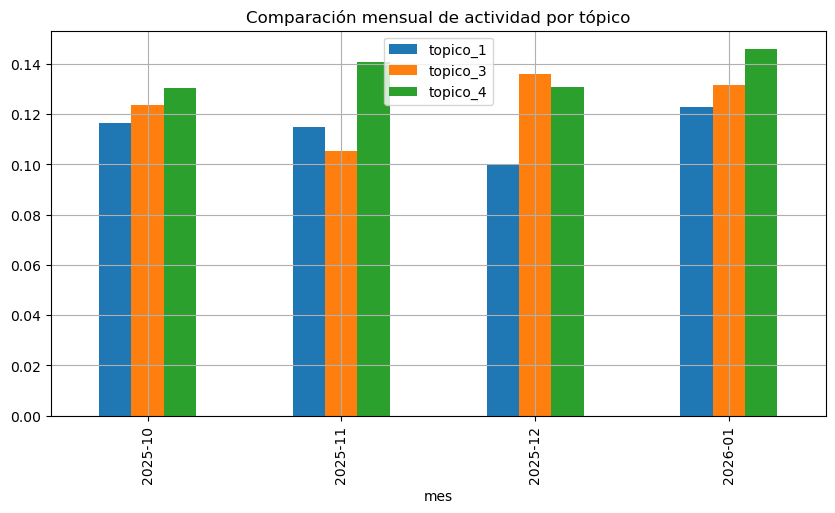

In [ ]:
medias_mensuales[["topico_1", "topico_3", "topico_4"]].plot(
    kind="bar",
    figsize=(10,5),
    title="Comparación mensual de actividad por tópico"
)
plt.grid(True)
plt.show()


In [ ]:
df_semana = pd.DataFrame({t: series_por_topico[t] for t in TOPICOS})
df_semana.index.name = "fecha"

# Día de la semana (0 = lunes, 6 = domingo)
df_semana["dia_semana"] = df_semana.index.dayofweek
df_semana["es_fin"] = df_semana["dia_semana"] >= 5   # True = sábado/domingo

# Media entre semana y fin de semana
medias_semana = df_semana.groupby("es_fin")[TOPICOS].mean().T
medias_semana.columns = ["Entre semana", "Fin de semana"]

medias_semana


Entre semana  Fin de semana
topico_0      0.122036       0.117505
topico_1      0.117246       0.094844
topico_2      0.145671       0.167342
topico_3      0.107713       0.159866
topico_4      0.149010       0.100371
topico_5      0.108139       0.133921
topico_6      0.120522       0.101149
topico_7      0.129662       0.125003

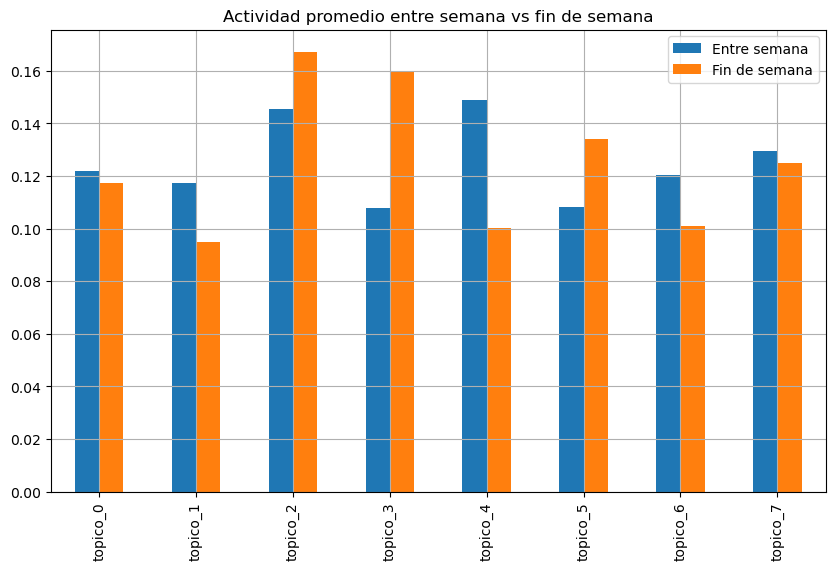

In [ ]:
medias_semana.plot(
    kind="bar",
    figsize=(10,6),
    title="Actividad promedio entre semana vs fin de semana"
)
plt.grid(True)
plt.show()


In [18]:
model = SARIMAX(
    endog=df_series_temporales["topico_1"],
    exog=X,                   # variables exógenas 
    order=(2, 0, 0),            # parte no estacional
    seasonal_order=(0, 1, 0, 7)  # parte estacional
)

results = model.fit()
print(results.summary())

                                     SARIMAX Results                                     
Dep. Variable:                          topico_1   No. Observations:                   90
Model:             SARIMAX(2, 0, 0)x(0, 1, 0, 7)   Log Likelihood                 163.004
Date:                           Thu, 04 Dec 2025   AIC                           -300.008
Time:                                   14:33:32   BIC                           -268.563
Sample:                               10-10-2025   HQIC                          -287.375
                                    - 01-07-2026                                         
Covariance Type:                             opg                                         
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Hostelería y Turismo                0.3175      0.216      1.470      0.142     

In [19]:
model = SARIMAX(
    endog=df_series_temporales["topico_3"],
    exog=X,                   # variables exógenas 
    order=(1, 0, 0),            # parte no estacional
    seasonal_order=(0, 1, 0, 7)  # parte estacional
)

results = model.fit()
print(results.summary())

                                     SARIMAX Results                                     
Dep. Variable:                          topico_3   No. Observations:                   90
Model:             SARIMAX(1, 0, 0)x(0, 1, 0, 7)   Log Likelihood                 109.164
Date:                           Thu, 04 Dec 2025   AIC                           -194.328
Time:                                   14:33:32   BIC                           -165.302
Sample:                               10-10-2025   HQIC                          -182.667
                                    - 01-07-2026                                         
Covariance Type:                             opg                                         
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Hostelería y Turismo                0.1285      0.649      0.198      0.843     

In [21]:
model = SARIMAX(
    endog=df_series_temporales["topico_2"],
    exog=X,                   # variables exógenas 
    order=(2, 0, 1),            # parte no estacional
    seasonal_order=(0, 1, 0, 7)  # parte estacional
)

results = model.fit()
print(results.summary())

                                     SARIMAX Results                                      
Dep. Variable:                           topico_2   No. Observations:                   90
Model:             SARIMAX(2, 0, 1)x(0, 1, [], 7)   Log Likelihood                 127.572
Date:                            Thu, 04 Dec 2025   AIC                           -227.145
Time:                                    14:39:38   BIC                           -193.281
Sample:                                10-10-2025   HQIC                          -213.540
                                     - 01-07-2026                                         
Covariance Type:                              opg                                         
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Hostelería y Turismo               -0.1249      0.498     -0.251      0.

In [22]:
model = SARIMAX(
    endog=df_series_temporales["topico_6"],
    exog=X,                   # variables exógenas 
    order=(1, 0, 1),            # parte no estacional
    seasonal_order=(0, 1, 0, 7)  # parte estacional
)

results = model.fit()
print(results.summary())

                                     SARIMAX Results                                      
Dep. Variable:                           topico_6   No. Observations:                   90
Model:             SARIMAX(1, 0, 1)x(0, 1, [], 7)   Log Likelihood                 150.494
Date:                            jue, 04 dic 2025   AIC                           -274.987
Time:                                    14:46:05   BIC                           -243.542
Sample:                                10-10-2025   HQIC                          -262.354
                                     - 01-07-2026                                         
Covariance Type:                              opg                                         
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Hostelería y Turismo                0.0752      0.325      0.232      0.